In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
    
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
# mpl.rcParams['figure.figsize'] = (6,6)
# mpl.rcParams['figure.dpi'] = 100
# mpl.rcParams["image.origin"] = 'lower'

In [94]:
config = {
    "base_dir":        "/eos/user/d/dvalsecc/www/VBSPlots/DNN_archive/FullRun2_v7",
    "plot_config":     "FullRun2_v7",
    "cut":             "res_sig",
    "model_version":   "cugini_scan/v1",
    "model_tag":       "1l_64",
    "samples_version": "v5",
    "cols": [
         "Lepton_eta",
        "Lepton_pt",
        "Zlep",
       "nJets30",
       "vbs_1_pt",
         "vbs_0_pt",
        "deltaeta_vbs",   
#        "vbs_1_qgl_res",
         "deltaphi_vbs",
        "mjj_vbs",
        "vjet_1_pt",
        "vjet_0_pt",
        "deltaeta_vjet",
         "mjj_vjet", 
#         #"PuppiMET_pt",
#         "deltaphi_vjet",
#         #"deltaR_lep_vbs",
#         #"deltaphi_lep_nu",
#         #"deltaR_vbs",
#         #"deltaR_vjet",     
          "Zvjets_0",
#         "Zvjets_1",
#         "Zlep",
#         ####"Asym_vbs",
#         #"Mtw_lep",
         "w_had_pt",
#         #"R_mw",
#         #"A_ww",
#         "Centr_vbs",
         "Centr_ww",
         "vbs_0_qglmorphed_res",
         "vbs_1_qglmorphed_res",
         "vjet_0_qglmorphed_res",
         "vjet_1_qglmorphed_res",
#         #"four_tag_jets_HT",
#         #"four_tag_jets_pt",
#         #"vbs_jets_HT", 
#         #"v_jets_HT",
#         #"vbs_jets_pt"
#         #"cosdeltatheta_Vhad",
#         "cosdeltatheta_vjet_0"        
        ],    
    "test_size": 0.15,
    "val_size":  0.0,
    "optimizer": "adam",
    "batch_size": 32,
    "decay_weights":  'inverse', #or cyclic
    "decay_weights_pars" : [0.00001,3,0.3], #[0.00005, 0.001, 15000] 
    "patience": [13,0.001]
}

import os

config_base_dir = os.path.join(config["base_dir"], config["plot_config"])

# create the model directory
model_dir   = os.path.join(config_base_dir, config["cut"] , "models",  config["model_version"])
os.makedirs(model_dir, exist_ok=True)

In [95]:
len(config["cols"])

20

In [4]:
# load numpy
samples_dir = os.path.join(config_base_dir, config["cut"] , "samples", config["samples_version"])
import pickle
signal = pickle.load(open(os.path.join(samples_dir, "for_training/signal_balanced.pkl"),     "rb"))
bkg    = pickle.load(open(os.path.join(samples_dir, "for_training/background_balanced.pkl"), "rb"))

In [47]:
print(signal.columns)

Index(['weight', 'Asym_vbs', 'Centr_vbs', 'Centr_ww', 'Lepton_eta',
       'Lepton_phi', 'Lepton_pt', 'Mtw_lep', 'Mww', 'PuppiMET_phi',
       'PuppiMET_pt', 'Zlep', 'Zvjets_0', 'cosdeltatheta_Vhad',
       'cosdeltatheta_lep', 'cosdeltatheta_vjet_0', 'cosdeltatheta_vjet_1',
       'deltaeta_vbs', 'deltaeta_vjet', 'deltaphi_WV', 'deltaphi_vbs',
       'deltaphi_vjet', 'deltatheta_Vhad', 'deltatheta_lep',
       'deltatheta_vjet_0', 'deltatheta_vjet_1', 'mjj_vbs', 'mjj_vjet',
       'nJets30', 'nvtxGood', 'theta_Vhad', 'theta_lep', 'theta_vjet_0',
       'theta_vjet_1', 'vbs_0_eta', 'vbs_0_phi', 'vbs_0_pt',
       'vbs_0_qglmorphed_res', 'vbs_1_eta', 'vbs_1_phi', 'vbs_1_pt',
       'vbs_1_qglmorphed_res', 'vjet_0_eta', 'vjet_0_phi', 'vjet_0_pt',
       'vjet_0_qglmorphed_res', 'vjet_1_eta', 'vjet_1_phi', 'vjet_1_pt',
       'vjet_1_qglmorphed_res', 'w_had_pt', 'w_lep_pt', 'lep_flavour',
       'sample_name', 'year', '_year', 'weight_norm'],
      dtype='object')


## Samples preparation for NN

In [5]:
## using 
## source /cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/setup.sh
#!pip3 install --user imbalanced-learn==0.5

In [5]:
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

N = 100000

X_sig = signal[config["cols"]].values
X_bkg = bkg[config["cols"]].values
Y_sig = np.ones(len(X_sig))
Y_bkg = np.zeros(len(X_bkg))
W_sig = (signal["weight_norm"]).values
W_bkg = (bkg["weight_norm"]).values
Wnn_sig = (signal["weight"]).values
Wnn_bkg = (bkg["weight"]).values

X = np.vstack([X_sig[:N], X_bkg[:N]])
Y = np.hstack([Y_sig[:N], Y_bkg[:N]])
W = np.hstack([W_sig[:N], W_bkg[:N]])
Wnn = np.hstack([Wnn_sig[:N], Wnn_bkg[:N]])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
#pickle.dump(scaler, open(f"{model_dir}/scaler_model.pkl", "wb"))

##  Balancing


In [9]:
X_train, X_test, y_train, y_test, W_train, W_test , Wnn_train, Wnn_test = \
            train_test_split(X_scaled, Y,  W, Wnn, test_size=0.5, random_state=41, stratify=Y)


#X_val,   X_test, y_val,   y_test, W_val,   W_test = train_test_split(X_temp,   y_temp, W_temp, test_size=config["val_size"]) ## test != val

In [10]:
print("Training   dataset: ", X_train.shape)
print("Test + Val dataset: ", X_test.shape)
#print("Testing    dataset: ", X_test.shape)
#print("Validation dataset: ", X_val.shape)

Training   dataset:  (100000, 5)
Test + Val dataset:  (100000, 5)


Create generators to balance signal and background

## Keras model

In [6]:
%load_ext autoreload
%autoreload 2

In [7]:
import tensorflow as tf

#from tensorflow import keras 
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense, Activation, BatchNormalization, Dropout , LeakyReLU

def get_models(spec, inputdim):
    model = Sequential()
    for i,n in enumerate(spec):
        if i ==0: 
            model.add(Dense(n, input_dim=inputdim, activation="relu"))
        else:
            model.add(Dense(n,  activation="relu"))
    model.add(Dense(1, activation="sigmoid"))
    return model


In [8]:
def run(nlayers, nnodes, N, output, use_weights=False ):
    feat = [nnodes] * nlayers
    # import local module that programmatically returns keras models
    import tensorflow as tf
    import dnn_models_cugini

    X_sig = signal[config["cols"]].values
    X_bkg = bkg[config["cols"]].values
    Y_sig = np.ones(len(X_sig))
    Y_bkg = np.zeros(len(X_bkg))
    W_sig = (signal["weight_norm"]).values
    W_bkg = (bkg["weight_norm"]).values
    Wnn_sig = (signal["weight"]).values
    Wnn_bkg = (bkg["weight"]).values

    X = np.vstack([X_sig[:N], X_bkg[:N]])
    Y = np.hstack([Y_sig[:N], Y_bkg[:N]])
    W = np.hstack([W_sig[:N], W_bkg[:N]])
    Wnn = np.hstack([Wnn_sig[:N], Wnn_bkg[:N]])

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    #pickle.dump(scaler, open(f"{model_dir}/scaler_model.pkl", "wb"))
    
    X_train, X_test, y_train, y_test, W_train, W_test , Wnn_train, Wnn_test = \
            train_test_split(X_scaled, Y,  W, Wnn, test_size=0.5, random_state=41, stratify=Y)


    model = get_models(feat, X_train.shape[1])

    model.compile(optimizer=config["optimizer"],
                loss='binary_crossentropy',
                metrics=['accuracy'])

    model.summary()

    ## TRAINING without random sampling
    import time
    start_time = time.time()
    import tensorflow as tf
    from tensorflow.keras import callbacks
    from tensorflow.keras.optimizers.schedules import InverseTimeDecay

    early_stopping = callbacks.EarlyStopping(monitor='val_loss', 
                                min_delta=config['patience'][1], patience=config['patience'][0], verbose=0, mode='auto', 
                                baseline=None, restore_best_weights=True)

    _callbacks = [early_stopping]


    # if config['decay_weights'] == 'inverse':
    #     lr_scheduler = callbacks.LearningRateScheduler(InverseTimeDecay(*config["decay_weights_pars"]))
    #     _callbacks.append(lr_scheduler)

    # if config['decay_weights'] == 'cyclic':
    #     from callbacks import CyclicLR  
    #     _callbacks.append(CyclicLR(base_lr=config["decay_weights_pars"][0],
    #                                 max_lr=config["decay_weights_pars"][1],
    #                                 step_size=config["decay_weights_pars"][2],
    #                                 mode="triangular2"))


    config["epochs"] = 100
    
    if use_weights:
        history = model.fit(
                X_train, y_train,
               sample_weight = W_train,
                epochs=config["epochs"],
                validation_data  = (X_test, y_test, W_test),
                callbacks=_callbacks,
                shuffle = True,
                batch_size= config["batch_size"],
                #callbacks = [], 
    #             class_weight= {0:1.8,1:1}
                verbose = True
            )
    else:
        history = model.fit(
                X_train, y_train,
                epochs=config["epochs"],
                validation_data  = (X_test, y_test),
                callbacks=_callbacks,
                shuffle = True,
                batch_size= config["batch_size"],
                #callbacks = [], 
    #             class_weight= {0:1.8,1:1}
                verbose = True
            )

    config["train_time"] = time.time() - start_time

    fig, ax1 = plt.subplots(figsize=(7,6), dpi=100)
    plt.plot(history.history["loss"], label="loss")
    plt.plot(history.history["val_loss"], label="val_loss")

    # Evalutation
    print(">>> Computing AUC...")

    from sklearn.metrics import roc_auc_score, roc_curve, auc

    pred_test  = model.predict(X_test,  batch_size=2048)
    pred_train = model.predict(X_train, batch_size=2048)
    #auc_w_test  = roc_auc_score(y_test, pred_test,  sample_weight=W_test)
    #auc_w_train = roc_auc_score(y_train,pred_train, sample_weight=W_train)
    fpW_test,  tpW_test,  thW_test  = roc_curve(y_test,  pred_test)
    fpW_train, tpW_train, thW_train = roc_curve(y_train, pred_train)
    auc_w_test = auc(fpW_test,tpW_test)
    auc_w_train = auc(fpW_train,tpW_train)

    #print("AUC score: " + str(auc))

    fig, ax1 = plt.subplots(figsize=(7,6), dpi=100)

    # ax1.plot(fp, tp, label=f"ROC (AUC={auc:.3f})", color="blue")
    ax1.plot(fpW_test,  tpW_test,  label=f"ROC test  (AUC={auc_w_test:.3f})", color="red")
    ax1.plot(fpW_train, tpW_train, label=f"ROC train (AUC={auc_w_train:.3f})", color="blue")

    ax1.set_xlabel("Bkg contamination", fontsize=18)
    ax1.set_ylabel("Signal efficiency", fontsize=18)

    #ax1.plot([0,1],[1,1],"b--")
    ax1.tick_params("y",labelsize="large")

    ax1.grid()

    ax1.legend(loc=(0.4, 0.5), fontsize="large")

    fig.tight_layout()

    name_model = "{}l_{}_{}var".format(nlayers, nnodes,X_train.shape[1] )
    layers = nlayers
    nodes = nnodes
    nvars = X_train.shape[1]
    ntrain = N
    auc_val = auc_w_test
    auc_train = auc_w_train

    with open(output,"a") as o:
        o.write("{};{};{};{};{};{};{}\n".format(name_model, layers, nodes, nvars, ntrain, auc_val, auc_train))


In [12]:
use_weights = False
N = 4000

for nlayer in [1,2,3,4]:
    for nnodes in [16,32,64,128]:
        print(nlayer,nnodes)
        run(nlayer,nnodes, N, "results_cugini.csv", use_weights)

1 16
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 16)                96        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
Total params: 113
Trainable params: 113
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
125/125 [==============================] - 1s 4ms/step - loss: 0.6740 - accuracy: 0.5867 - val_loss: 0.6249 - val_accuracy: 0.6543
Epoch 2/100
125/125 [==============================] - 0s 2ms/step - loss: 0.5918 - accuracy: 0.6967 - val_loss: 0.5937 - val_accuracy: 0.6825
Epoch 3/100
125/125 [==============================] - 0s 2ms/step - loss: 0.5736 - accuracy: 0.7072 - val_loss: 0.5874 - val_accuracy: 0.6840
Epoch 4/100
125/125 [==============================] - 0s 3ms/step - loss: 0.5680 - 

KeyboardInterrupt: 

In [69]:
run(2,64, 2511, "test.csv", False)

KeyError: "['Zvjets_1'] not in index"

In [40]:
df = pd.read_csv("results_cugini.csv",sep=";")

In [41]:
df

name  layers  nodes  nvars  ntrain   auc_val  auc_train
0    1l_16_5var       1     16      5    4000  0.766912   0.792947
1    1l_32_5var       1     32      5    4000  0.766997   0.792211
2    1l_64_5var       1     64      5    4000  0.767213   0.793823
3   1l_128_5var       1    128      5    4000  0.767717   0.794617
4    2l_16_5var       2     16      5    4000  0.769414   0.793835
5    2l_32_5var       2     32      5    4000  0.766220   0.798223
6    2l_64_5var       2     64      5    4000  0.767477   0.797234
7   2l_128_5var       2    128      5    4000  0.769059   0.795686
8    3l_16_5var       3     16      5    4000  0.766533   0.793316
9    3l_32_5var       3     32      5    4000  0.769290   0.794112
10   3l_64_5var       3     64      5    4000  0.767948   0.793903
11  3l_128_5var       3    128      5    4000  0.766856   0.798090
12   4l_16_5var       4     16      5    4000  0.765231   0.790710
13   4l_32_5var       4     32      5    4000  0.764069   0.795664
14   4l_64_5var       4     64      5    4000  0.766433   0.799602
15  4l_128_5var       4    128      5    4000  0.767606   0.803448
16   1l_16_3var       1     16      3    4000  0.741433   0.769424
17   1l_32_3var       1     32      3    4000  0.742125   0.769155
18   1l_64_3var       1     64      3    4000  0.742062   0.770373
19  1l_128_3var       1    128      3    4000  0.741745   0.771124
20   2l_16_3var       2     16      3    4000  0.742195   0.771356
21   2l_32_3var       2     32      3    4000  0.741372   0.768564
22   2l_64_3var       2     64      3    4000  0.743500   0.772949
23  2l_128_3var       2    128      3    4000  0.741807   0.774349
24   3l_16_3var       3     16      3    4000  0.740978   0.771859
25   3l_32_3var       3     32      3    4000  0.742471   0.770743
26   3l_64_3var       3     64      3    4000  0.743413   0.770778
27  3l_128_3var       3    128      3    4000  0.742872   0.769972
28   4l_16_3var       4     16      3    4000  0.741456   0.773436
29   4l_32_3var       4     32      3    4000  0.742015   0.770649
30   4l_64_3var       4     64      3    4000  0.742087   0.776928
31  4l_128_3var       4    128      3    4000  0.742049   0.775790
32   1l_16_2var       1     16      2    4000  0.662766   0.683272
33   1l_32_2var       1     32      2    4000  0.663305   0.681471
34   1l_64_2var       1     64      2    4000  0.662652   0.683352
35  1l_128_2var       1    128      2    4000  0.663684   0.684036
36   2l_16_2var       2     16      2    4000  0.663679   0.686692
37   2l_32_2var       2     32      2    4000  0.663667   0.684859
38   2l_64_2var       2     64      2    4000  0.664855   0.685609
39  2l_128_2var       2    128      2    4000  0.664281   0.686928
40   3l_16_2var       3     16      2    4000  0.663596   0.683802
41   3l_32_2var       3     32      2    4000  0.663897   0.681660
42   3l_64_2var       3     64      2    4000  0.664332   0.685649
43  3l_128_2var       3    128      2    4000  0.664236   0.684474
44   4l_16_2var       4     16      2    4000  0.664492   0.684319
45   4l_32_2var       4     32      2    4000  0.664121   0.686606
46   4l_64_2var       4     64      2    4000  0.664054   0.684077
47  4l_128_2var       4    128      2    4000  0.663901   0.685684

In [20]:
import matplotlib.pyplot as plt
#import mplhep as hep
#plt.style.use(hep.style.CMS)
# Overall - both left and right annotation

Text(0, 0.5, 'AUC')

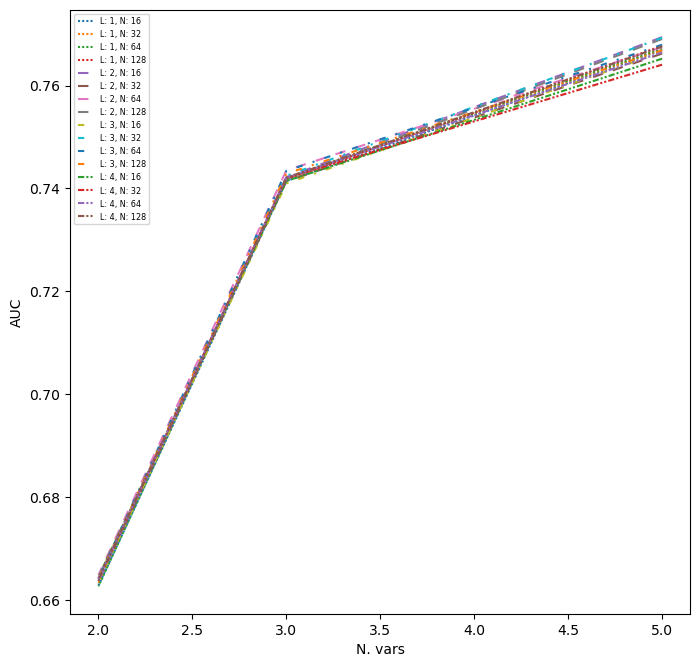

In [42]:
fig, ax1 = plt.subplots(figsize=(8,8), dpi=100)
linestyle_tuple = [
     ('dotted',                (0, (1, 1))),

     ('dashed',                (0, (5, 5))),

     ('dashdotted',            (0, (3, 5, 1, 5))),

     ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1)))]

for nlayer in [1,2,3,4]:
    for nnodes in [16,32,64,128]:
        a = df[(df.nodes==nnodes)&(df.layers==nlayer) & (df.ntrain==4000)]
        ax1.plot(a.nvars, a.auc_val, label="L: {}, N: {}".format(nlayer,nnodes), linestyle=linestyle_tuple[nlayer-1][1])
ax1.legend(fontsize="xx-small")
ax1.set_xlabel("N. vars")
ax1.set_ylabel("AUC")

Text(0, 0.5, 'AUC')

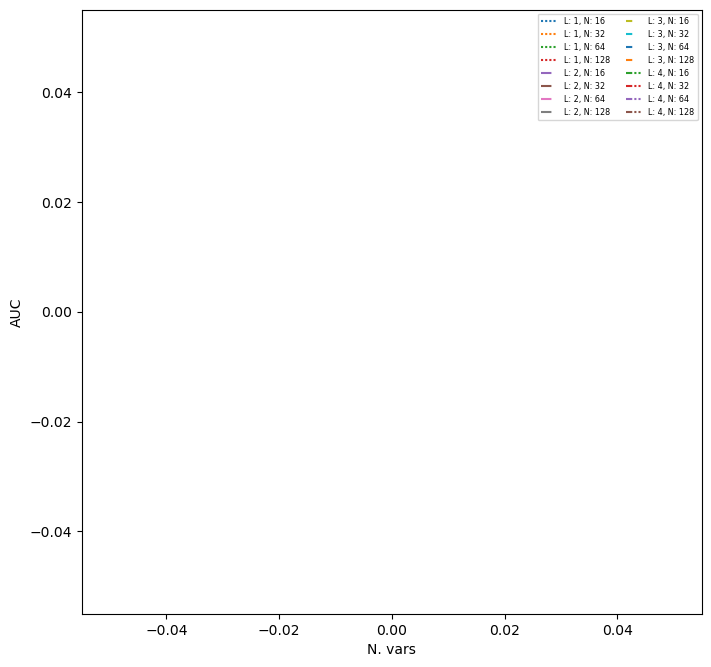

In [15]:
fig, ax1 = plt.subplots(figsize=(8,8), dpi=100)
linestyle_tuple = [
     ('dotted',                (0, (1, 1))),

     ('dashed',                (0, (5, 5))),

     ('dashdotted',            (0, (3, 5, 1, 5))),

     ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1)))]

for nlayer in [1,2,3,4]:
    for nnodes in [16,32,64,128]:
        a = df[(df.nodes==nnodes)&(df.layers==nlayer) & (df.ntrain==4000) & (df.nvars> 2)]
        ax1.plot(a.nvars, a.auc_val, label="L: {}, N: {}".format(nlayer,nnodes), linestyle=linestyle_tuple[nlayer-1][1])
ax1.legend(fontsize="xx-small",ncol=2)
ax1.set_xlabel("N. vars")
ax1.set_ylabel("AUC")

316
Model: "sequential_62"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_259 (Dense)            (None, 64)                1216      
_________________________________________________________________
dense_260 (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_261 (Dense)            (None, 1)                 65        
Total params: 5,441
Trainable params: 5,441
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
10/10 [==============================] - 0s 19ms/step - loss: 0.6880 - accuracy: 0.5854 - val_loss: 0.6445 - val_accuracy: 0.6424
Epoch 2/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6189 - accuracy: 0.6456 - val_loss: 0.6219 - val_accuracy: 0.6804
Epoch 3/100
10/10 [==============================] - 0s 5ms/step - loss: 0.5790 - accuracy: 0.

266/266 [==============================] - 1s 2ms/step - loss: 0.4989 - accuracy: 0.7562 - val_loss: 0.5240 - val_accuracy: 0.7429
Epoch 9/100
266/266 [==============================] - 0s 2ms/step - loss: 0.4946 - accuracy: 0.7635 - val_loss: 0.5257 - val_accuracy: 0.7394
Epoch 10/100
266/266 [==============================] - 1s 2ms/step - loss: 0.4908 - accuracy: 0.7601 - val_loss: 0.5236 - val_accuracy: 0.7348
Epoch 11/100
266/266 [==============================] - 1s 2ms/step - loss: 0.4878 - accuracy: 0.7625 - val_loss: 0.5271 - val_accuracy: 0.7361
Epoch 12/100
266/266 [==============================] - 1s 2ms/step - loss: 0.4839 - accuracy: 0.7667 - val_loss: 0.5242 - val_accuracy: 0.7379
Epoch 13/100
266/266 [==============================] - 1s 2ms/step - loss: 0.4805 - accuracy: 0.7684 - val_loss: 0.5298 - val_accuracy: 0.7349
Epoch 14/100
266/266 [==============================] - 1s 2ms/step - loss: 0.4781 - accuracy: 0.7688 - val_loss: 0.5329 - val_accuracy: 0.7343
Epoch 

Epoch 13/100
1374/1374 [==============================] - 3s 2ms/step - loss: 0.4963 - accuracy: 0.7561 - val_loss: 0.5248 - val_accuracy: 0.7396
Epoch 14/100
1374/1374 [==============================] - 3s 2ms/step - loss: 0.4949 - accuracy: 0.7556 - val_loss: 0.5317 - val_accuracy: 0.7358
Epoch 15/100
1374/1374 [==============================] - 3s 2ms/step - loss: 0.4935 - accuracy: 0.7563 - val_loss: 0.5248 - val_accuracy: 0.7395
Epoch 16/100
1374/1374 [==============================] - 3s 2ms/step - loss: 0.4923 - accuracy: 0.7586 - val_loss: 0.5271 - val_accuracy: 0.7394
Epoch 17/100
1374/1374 [==============================] - 3s 2ms/step - loss: 0.4906 - accuracy: 0.7598 - val_loss: 0.5265 - val_accuracy: 0.7367
Epoch 18/100
1374/1374 [==============================] - 3s 2ms/step - loss: 0.4896 - accuracy: 0.7598 - val_loss: 0.5294 - val_accuracy: 0.7366
Epoch 19/100
1374/1374 [==============================] - 3s 2ms/step - loss: 0.4883 - accuracy: 0.7599 - val_loss: 0.5304 -

719
Model: "sequential_71"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_287 (Dense)            (None, 128)               2432      
_________________________________________________________________
dense_288 (Dense)            (None, 128)               16512     
_________________________________________________________________
dense_289 (Dense)            (None, 128)               16512     
_________________________________________________________________
dense_290 (Dense)            (None, 1)                 129       
Total params: 35,585
Trainable params: 35,585
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
23/23 [==============================] - 0s 12ms/step - loss: 0.6227 - accuracy: 0.6551 - val_loss: 0.5818 - val_accuracy: 0.6857
Epoch 2/100
23/23 [==============================] - 0s 3ms/step - loss: 0.5051 - accuracy: 0.7691 - 

<ipython-input-8-b8941751648a>:93: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax1 = plt.subplots(figsize=(7,6), dpi=100)


3727
Model: "sequential_73"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_295 (Dense)            (None, 128)               2432      
_________________________________________________________________
dense_296 (Dense)            (None, 128)               16512     
_________________________________________________________________
dense_297 (Dense)            (None, 128)               16512     
_________________________________________________________________
dense_298 (Dense)            (None, 1)                 129       
Total params: 35,585
Trainable params: 35,585
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
117/117 [==============================] - 1s 5ms/step - loss: 0.5517 - accuracy: 0.7153 - val_loss: 0.5353 - val_accuracy: 0.7395
Epoch 2/100
117/117 [==============================] - 0s 3ms/step - loss: 0.5044 - accuracy: 0.752

604/604 [==============================] - 2s 4ms/step - loss: 0.5516 - accuracy: 0.7217 - val_loss: 0.5256 - val_accuracy: 0.7366
Epoch 2/100
604/604 [==============================] - 2s 3ms/step - loss: 0.5296 - accuracy: 0.7387 - val_loss: 0.5226 - val_accuracy: 0.7379
Epoch 3/100
604/604 [==============================] - 2s 3ms/step - loss: 0.5238 - accuracy: 0.7408 - val_loss: 0.5229 - val_accuracy: 0.7398
Epoch 4/100
604/604 [==============================] - 2s 3ms/step - loss: 0.5198 - accuracy: 0.7428 - val_loss: 0.5182 - val_accuracy: 0.7407
Epoch 5/100
604/604 [==============================] - 2s 3ms/step - loss: 0.5125 - accuracy: 0.7484 - val_loss: 0.5250 - val_accuracy: 0.7369
Epoch 6/100
604/604 [==============================] - 2s 3ms/step - loss: 0.5089 - accuracy: 0.7534 - val_loss: 0.5228 - val_accuracy: 0.7426
Epoch 7/100
604/604 [==============================] - 2s 3ms/step - loss: 0.5024 - accuracy: 0.7529 - val_loss: 0.5307 - val_accuracy: 0.7427
Epoch 8/100

52/52 [==============================] - 0s 8ms/step - loss: 0.5555 - accuracy: 0.7269 - val_loss: 0.5356 - val_accuracy: 0.7483
Epoch 2/100
52/52 [==============================] - 0s 4ms/step - loss: 0.4716 - accuracy: 0.7838 - val_loss: 0.5292 - val_accuracy: 0.7532
Epoch 3/100
52/52 [==============================] - 0s 4ms/step - loss: 0.4455 - accuracy: 0.7972 - val_loss: 0.5344 - val_accuracy: 0.7453
Epoch 4/100
52/52 [==============================] - 0s 4ms/step - loss: 0.4164 - accuracy: 0.8112 - val_loss: 0.5438 - val_accuracy: 0.7581
Epoch 5/100
52/52 [==============================] - 0s 4ms/step - loss: 0.3880 - accuracy: 0.8314 - val_loss: 0.5794 - val_accuracy: 0.7477
Epoch 6/100
52/52 [==============================] - 0s 4ms/step - loss: 0.3623 - accuracy: 0.8363 - val_loss: 0.5660 - val_accuracy: 0.7410
Epoch 7/100
52/52 [==============================] - 0s 3ms/step - loss: 0.3198 - accuracy: 0.8662 - val_loss: 0.6491 - val_accuracy: 0.7361
Epoch 8/100
52/52 [======

1374/1374 [==============================] - 4s 3ms/step - loss: 0.4960 - accuracy: 0.7580 - val_loss: 0.5274 - val_accuracy: 0.7404
Epoch 10/100
1374/1374 [==============================] - 5s 4ms/step - loss: 0.4927 - accuracy: 0.7596 - val_loss: 0.5279 - val_accuracy: 0.7374
Epoch 11/100
1374/1374 [==============================] - 5s 4ms/step - loss: 0.4884 - accuracy: 0.7624 - val_loss: 0.5287 - val_accuracy: 0.7379
Epoch 12/100
1374/1374 [==============================] - 5s 3ms/step - loss: 0.4821 - accuracy: 0.7664 - val_loss: 0.5323 - val_accuracy: 0.7336
Epoch 13/100
1374/1374 [==============================] - 5s 3ms/step - loss: 0.4770 - accuracy: 0.7707 - val_loss: 0.5373 - val_accuracy: 0.7351
Epoch 14/100
1374/1374 [==============================] - 5s 4ms/step - loss: 0.4707 - accuracy: 0.7735 - val_loss: 0.5436 - val_accuracy: 0.7323
Epoch 15/100
1374/1374 [==============================] - 4s 3ms/step - loss: 0.4630 - accuracy: 0.7784 - val_loss: 0.5629 - val_accuracy

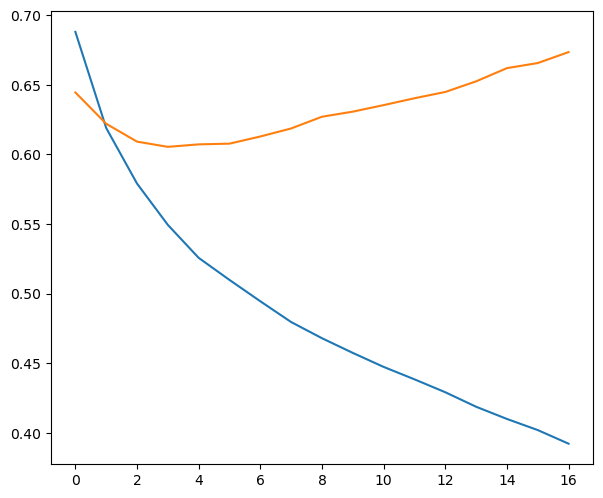

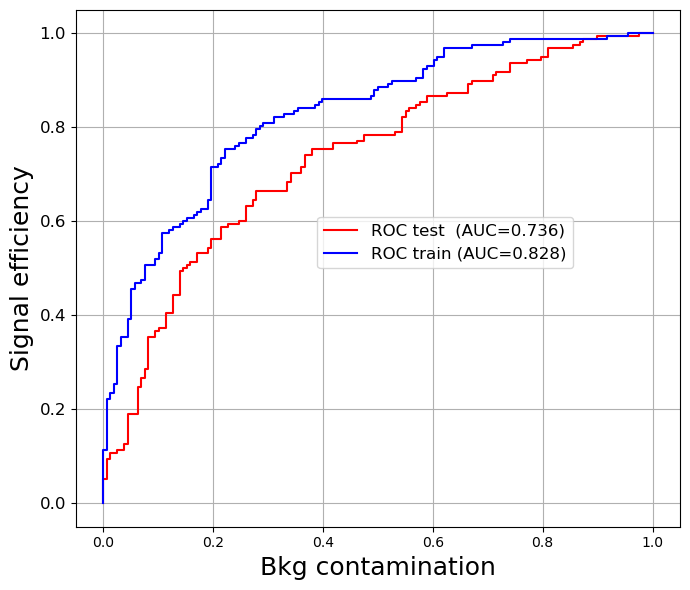

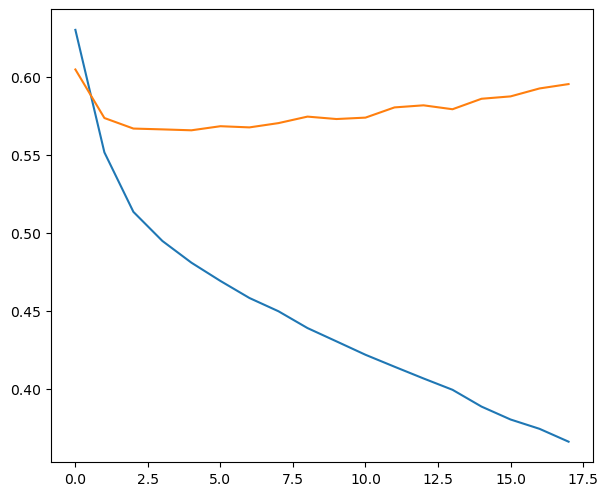

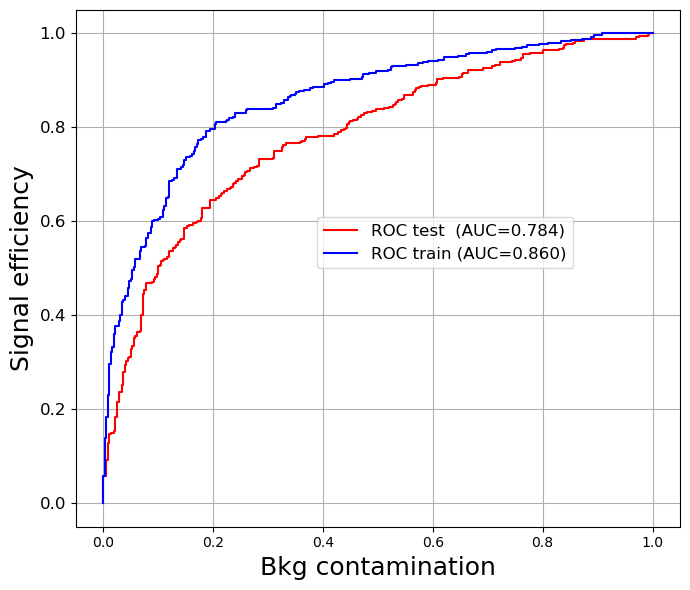

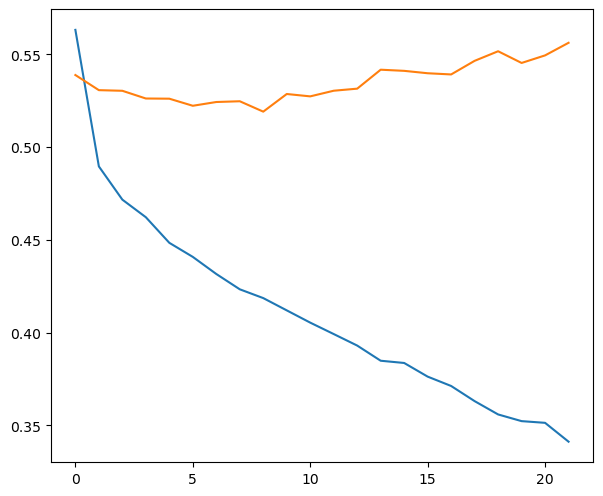

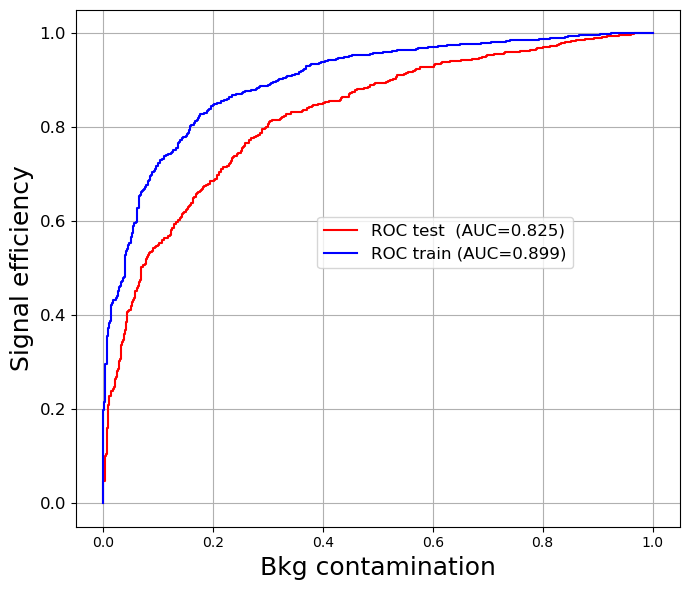

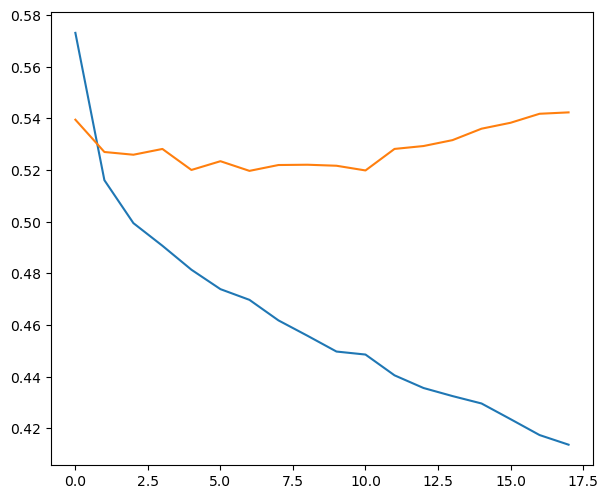

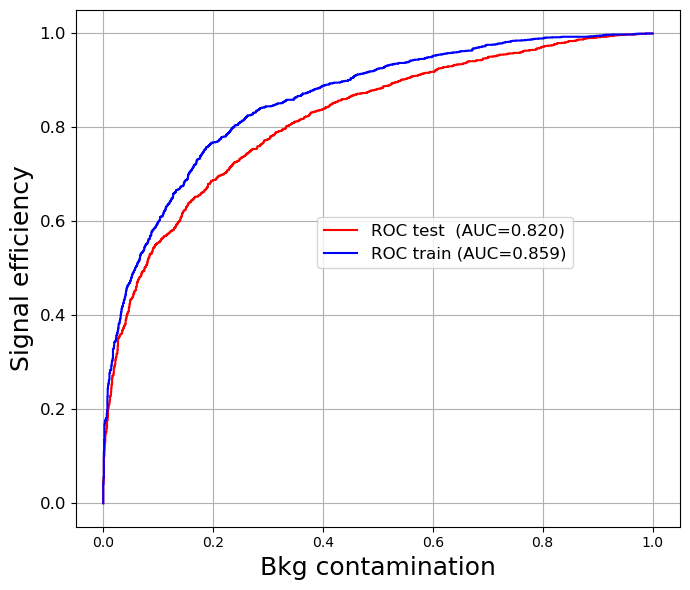

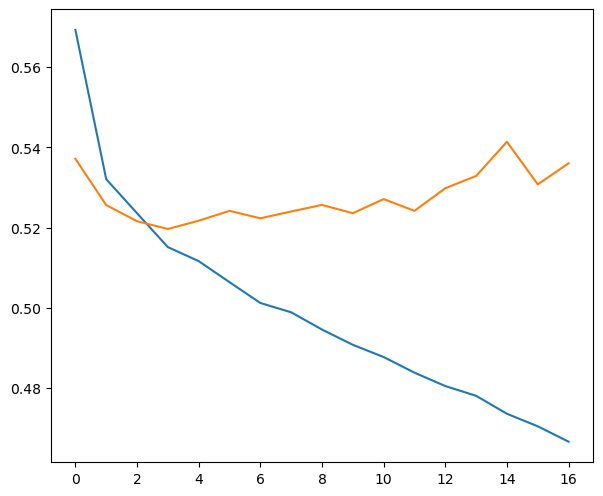

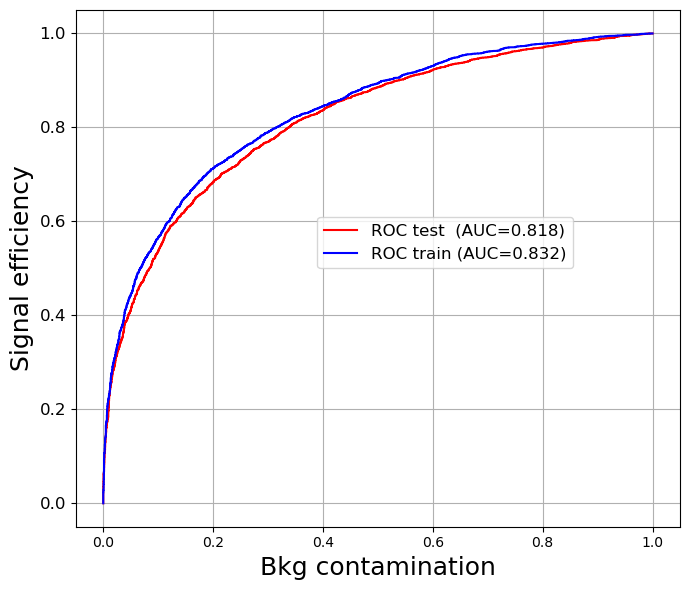

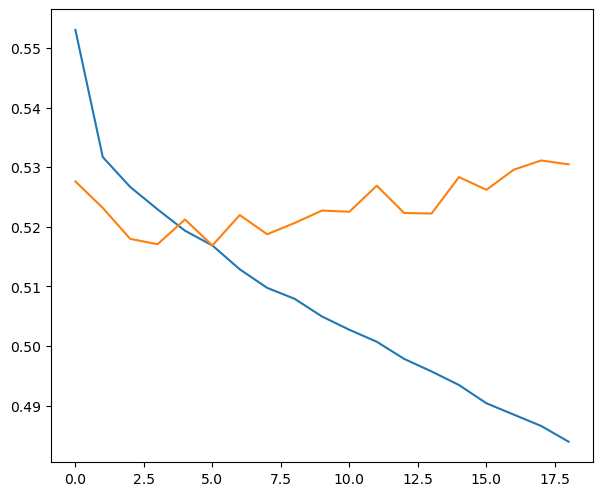

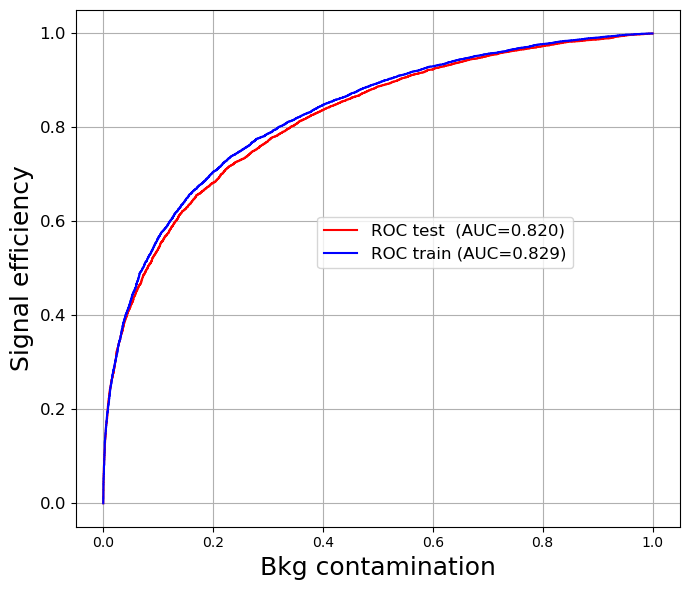

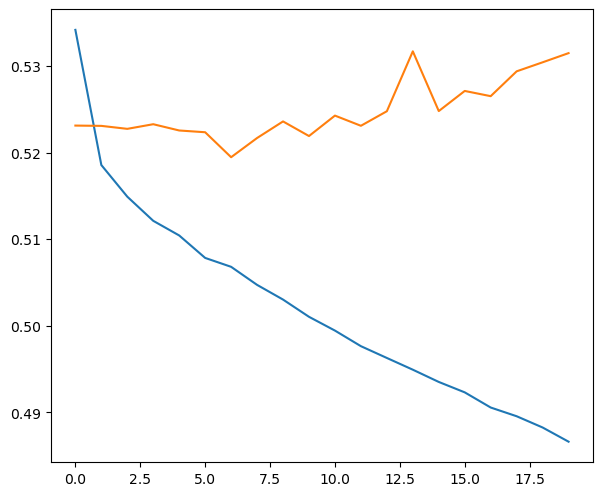

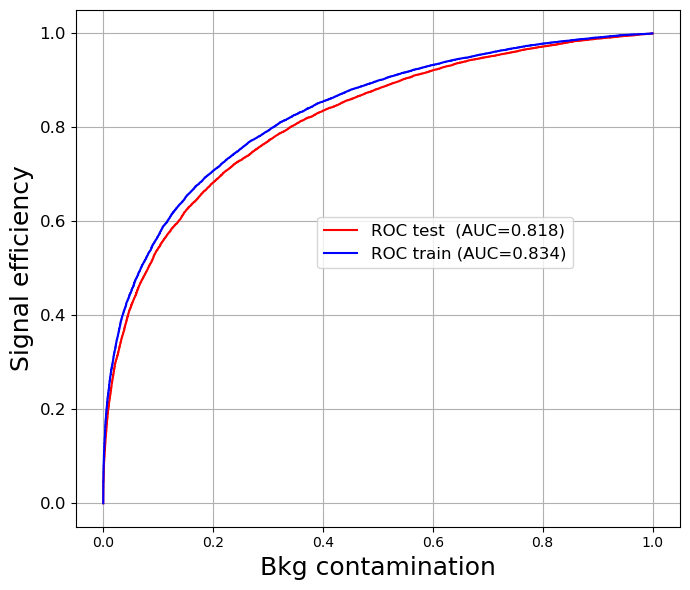

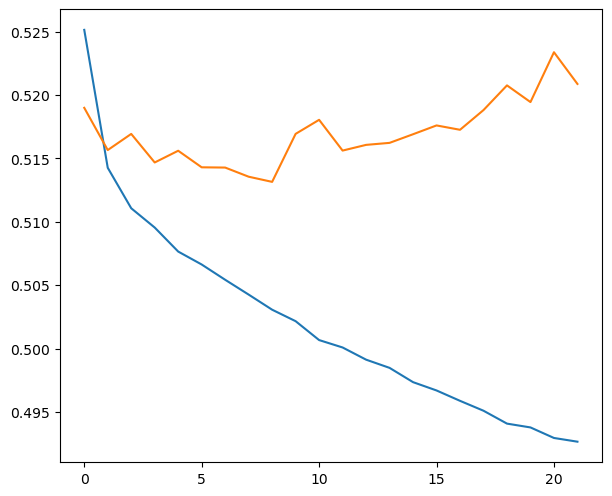

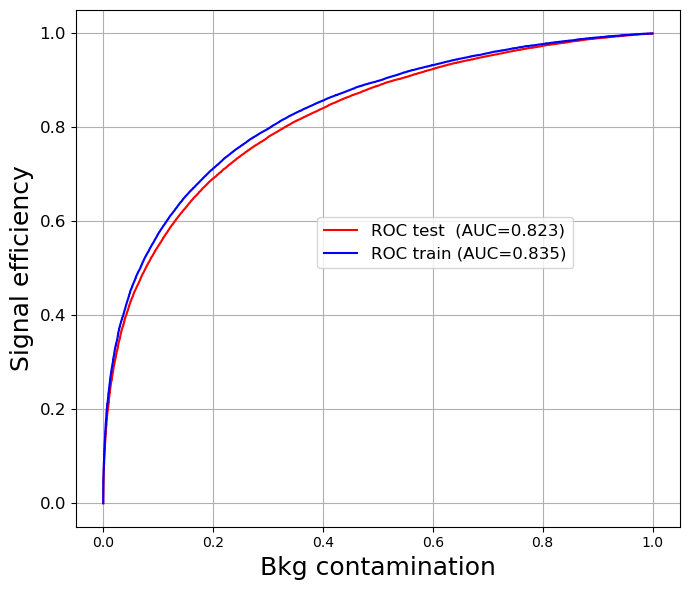

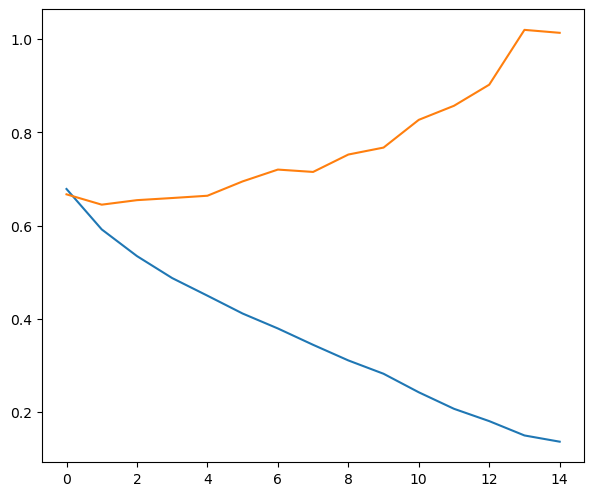

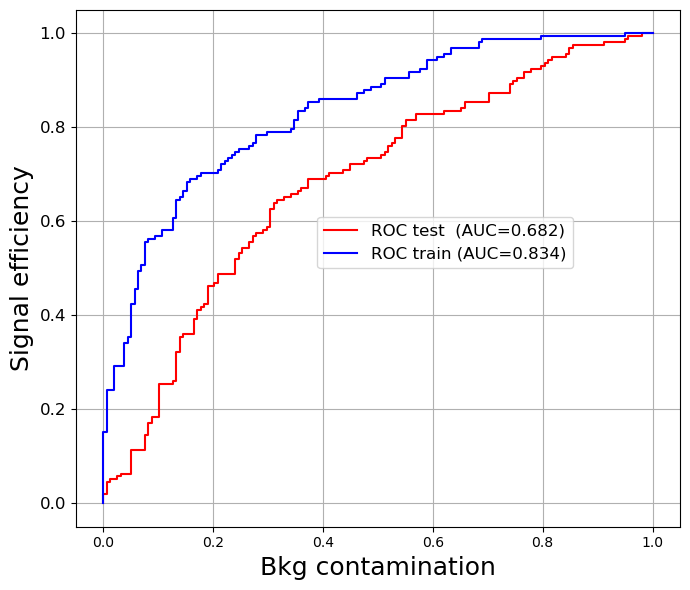

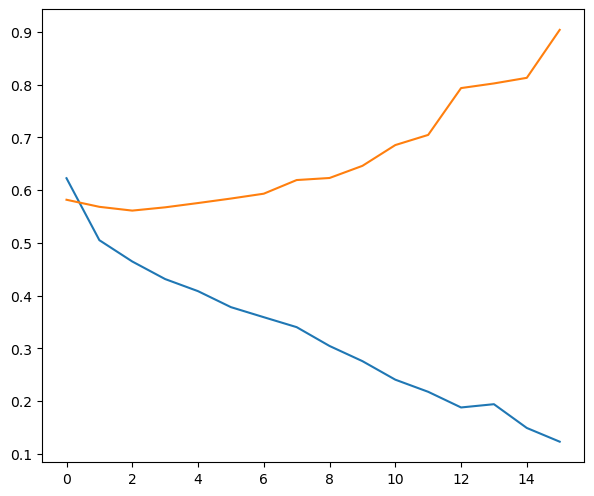

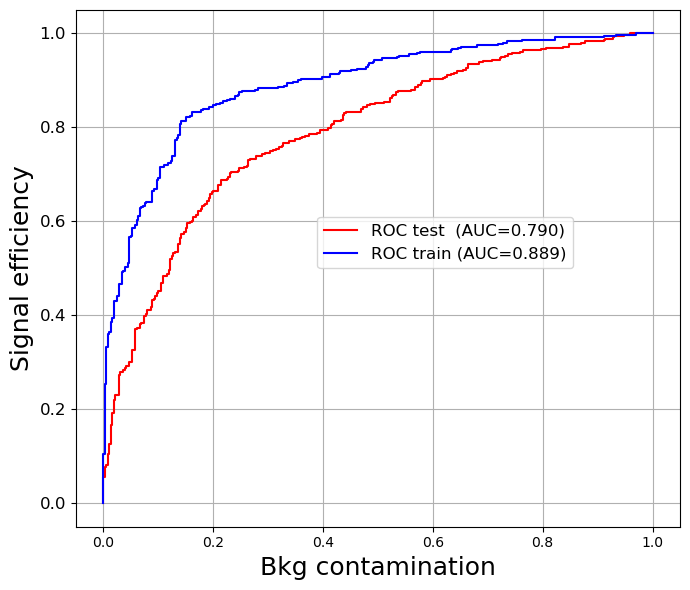

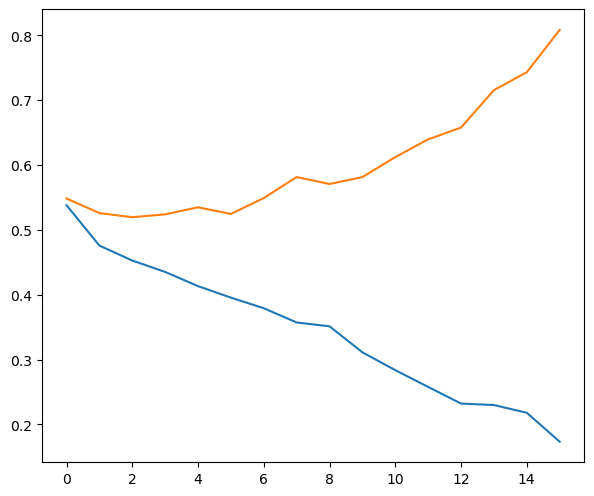

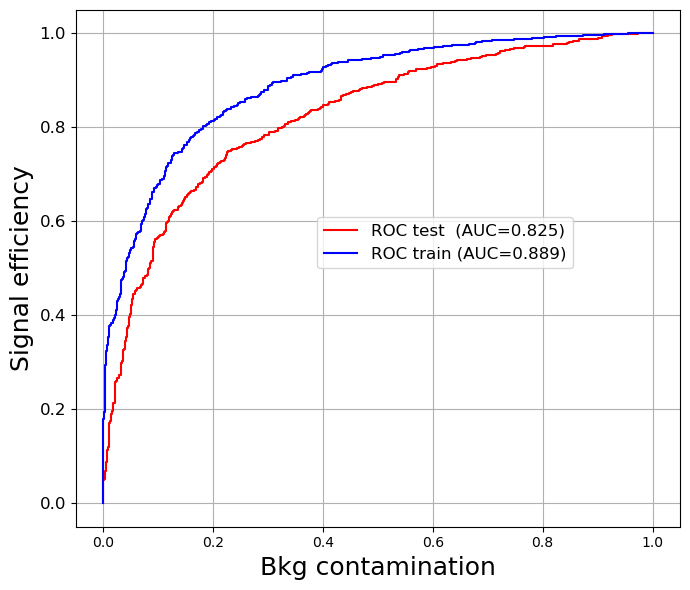

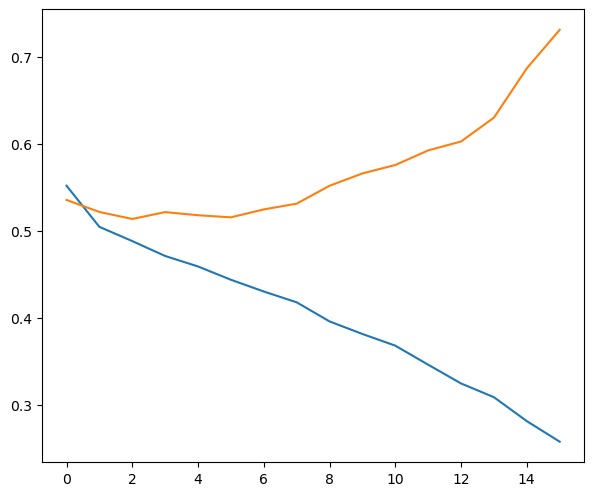

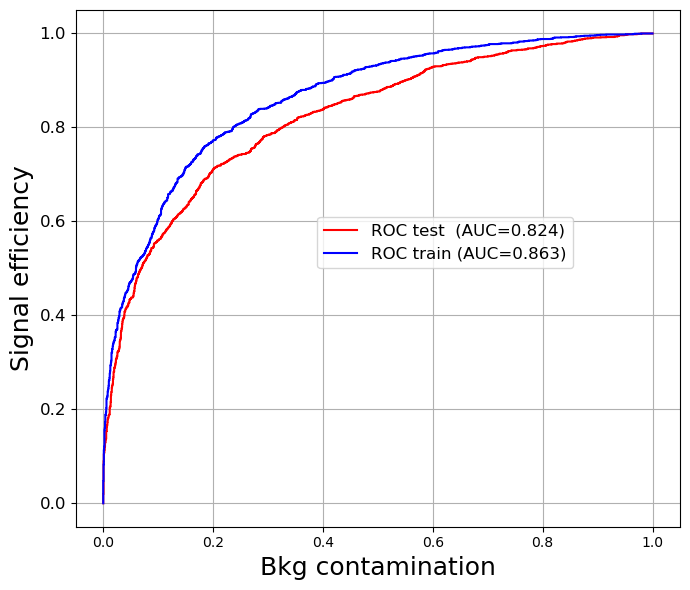

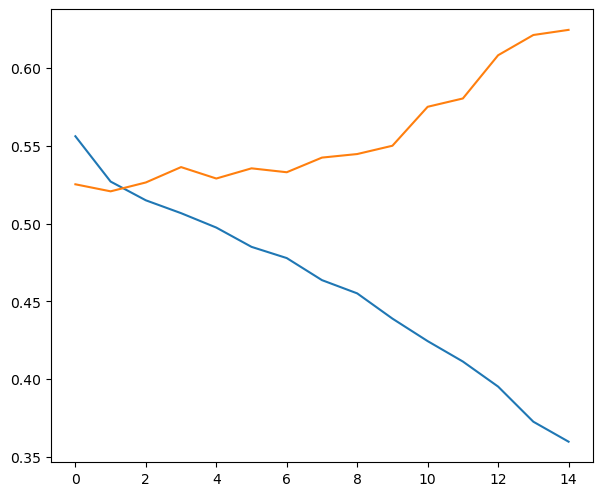

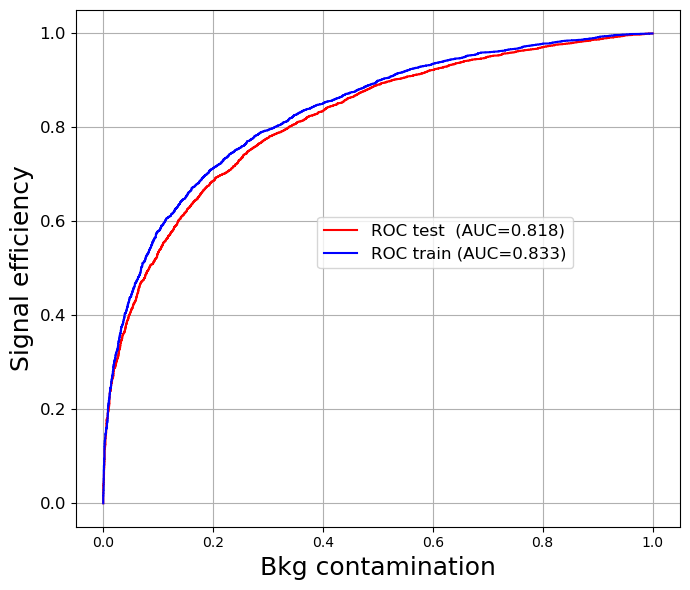

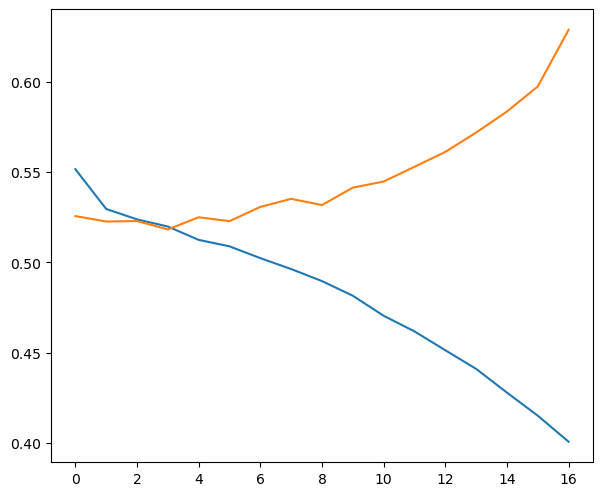

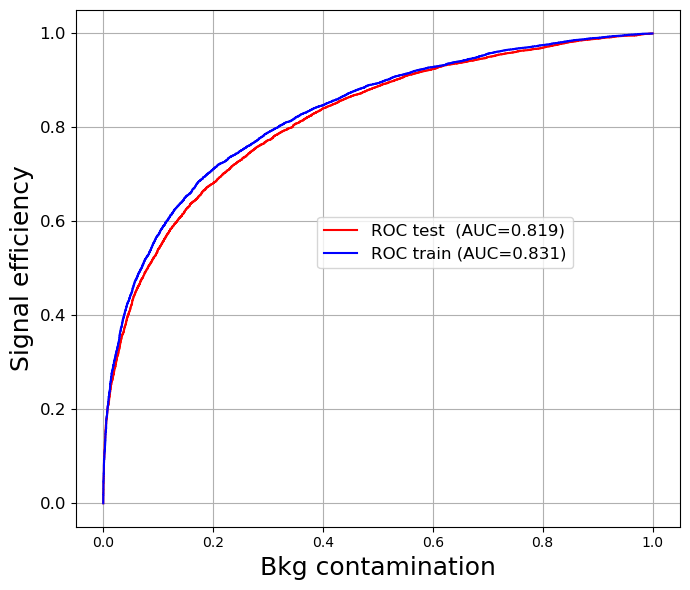

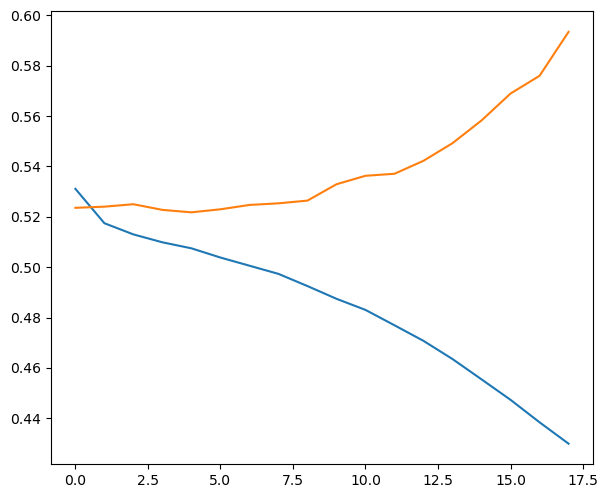

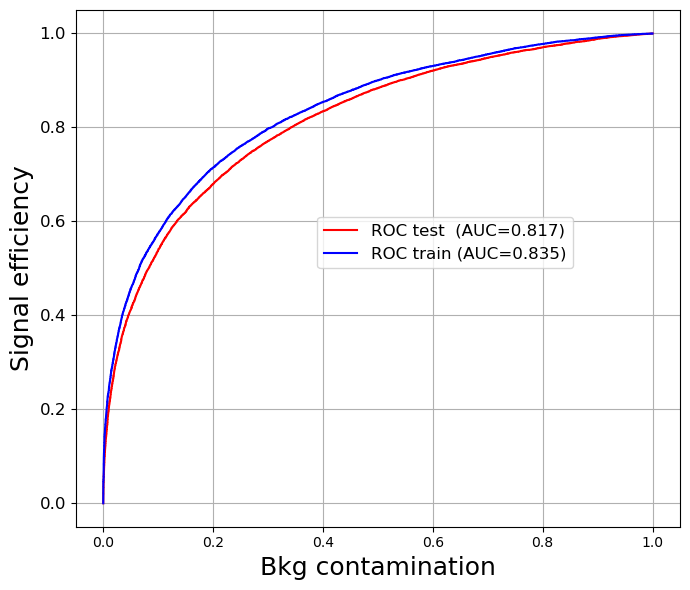

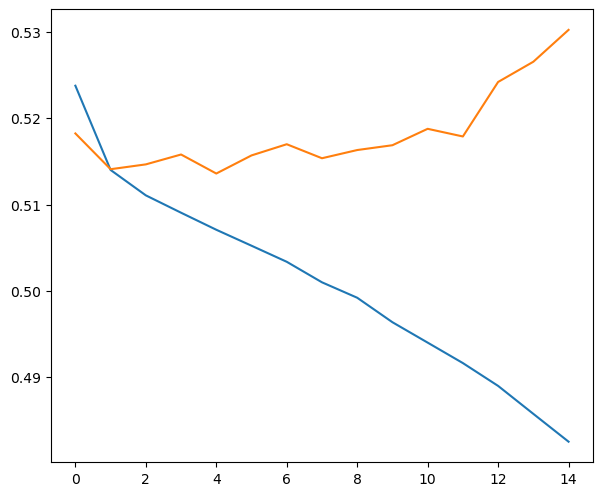

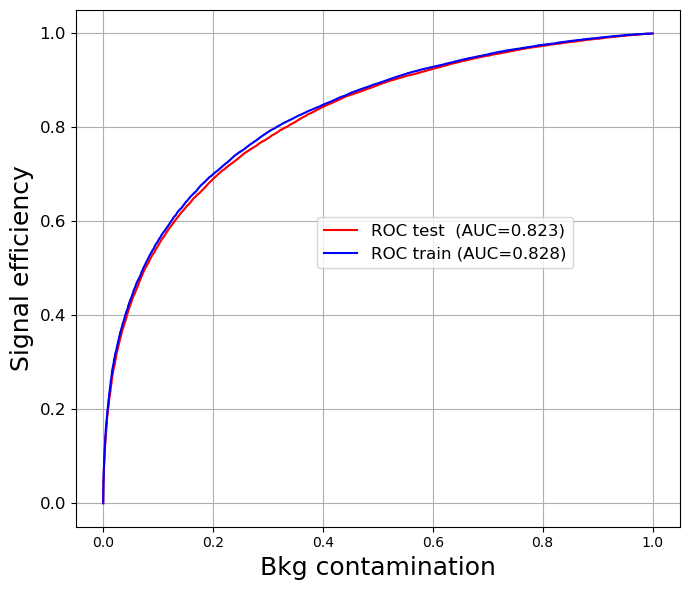

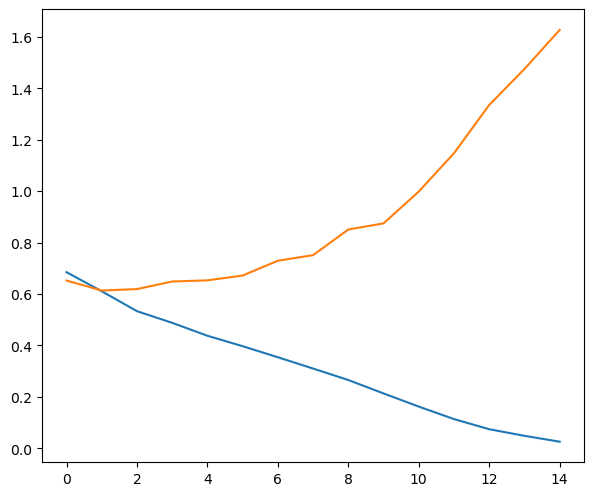

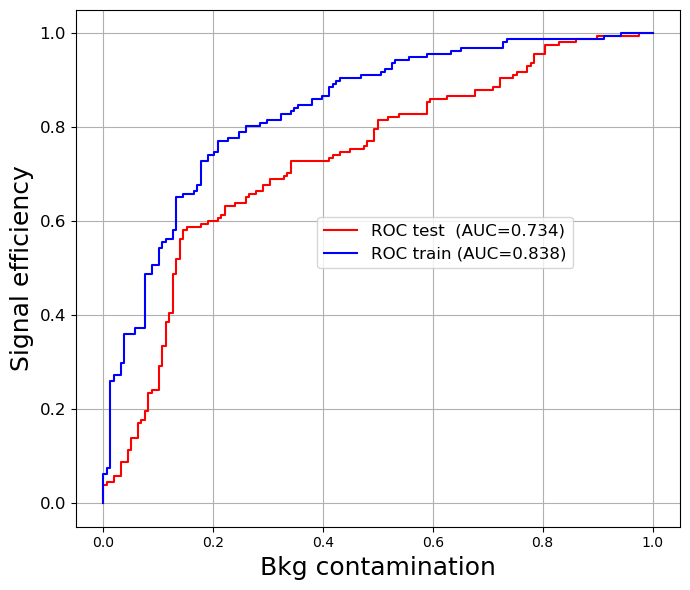

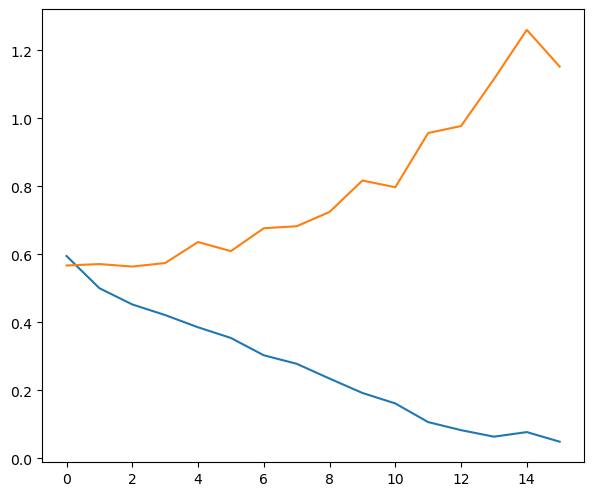

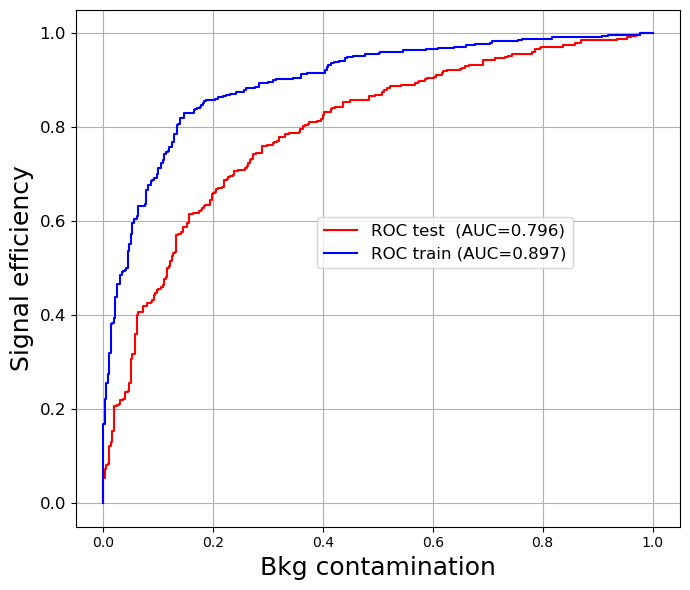

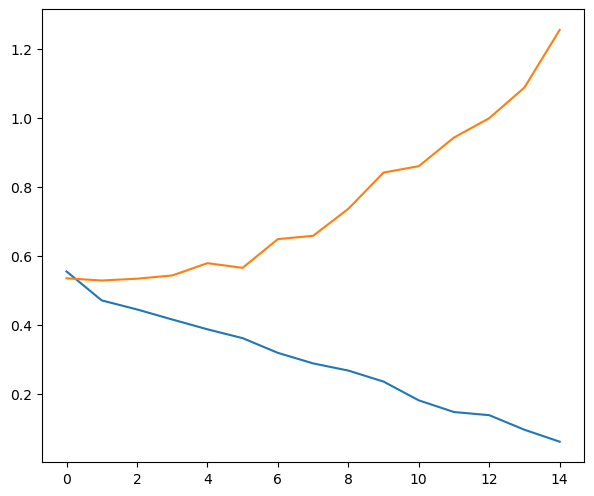

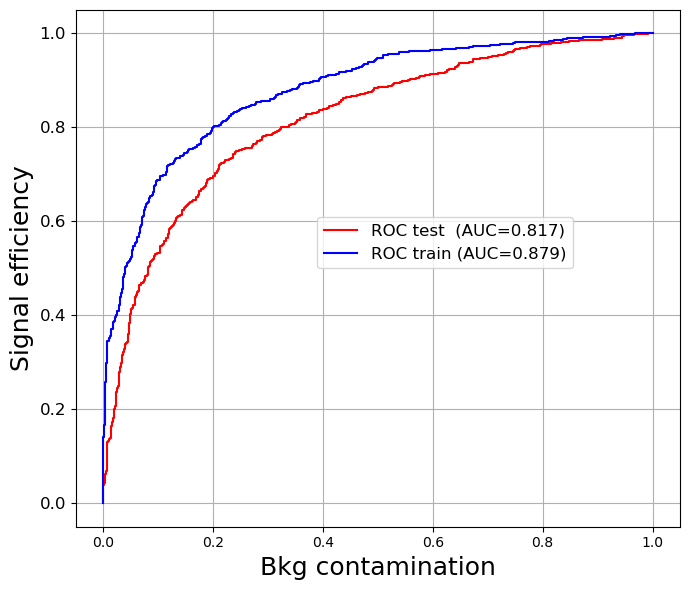

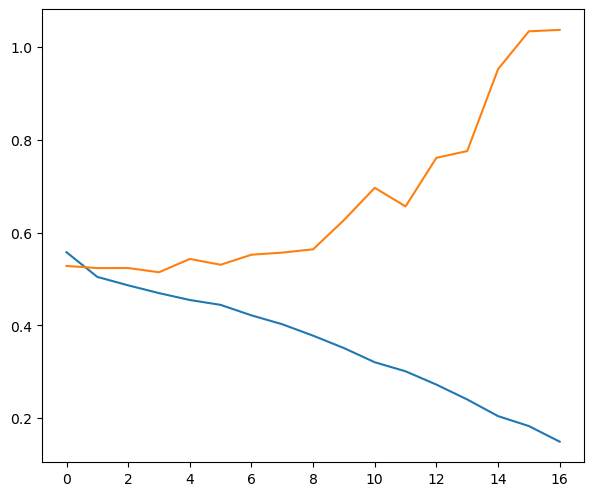

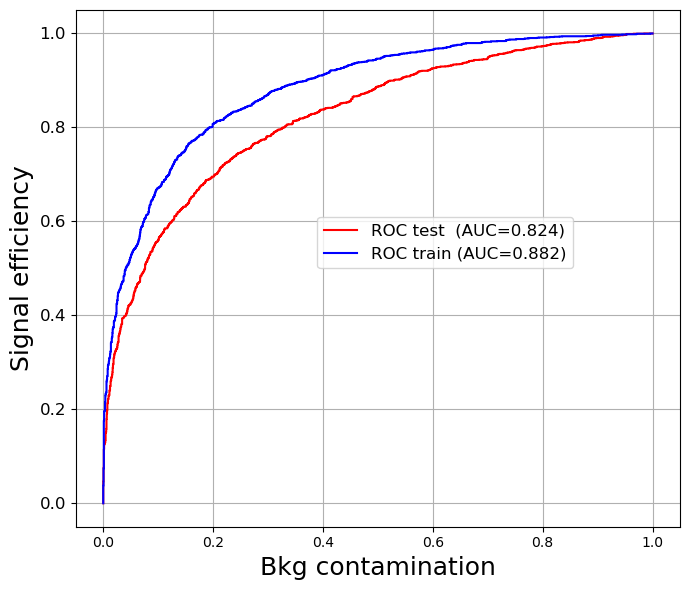

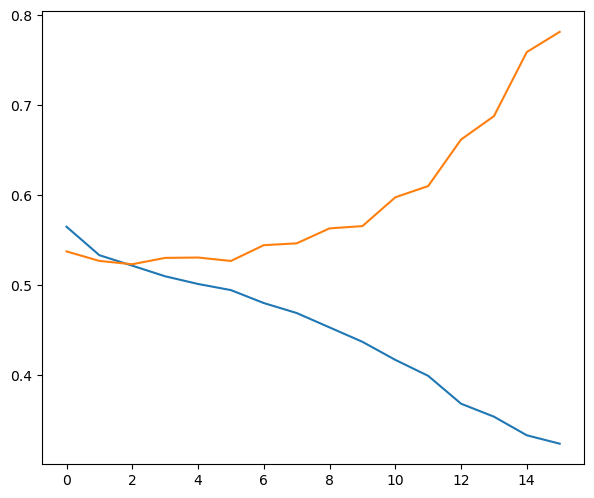

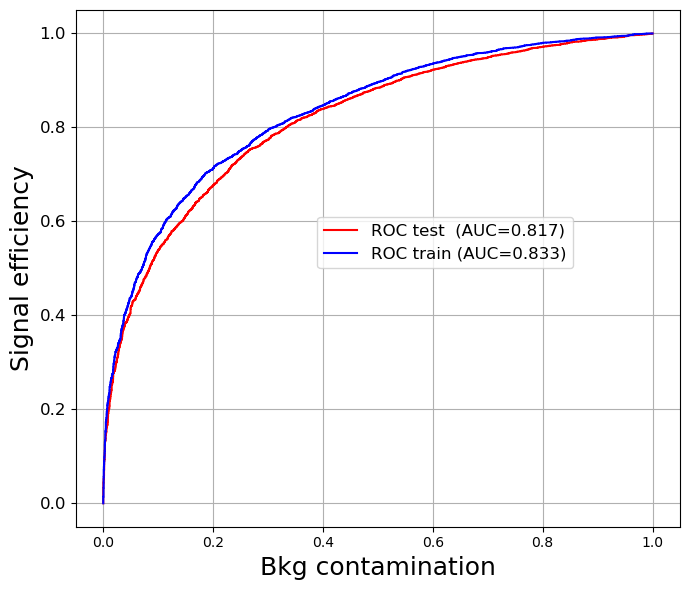

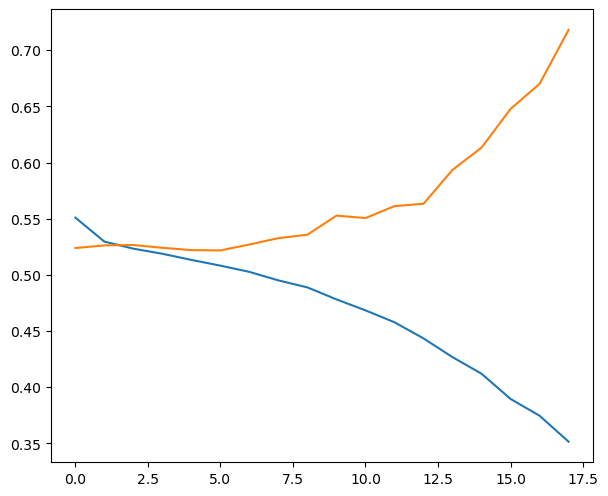

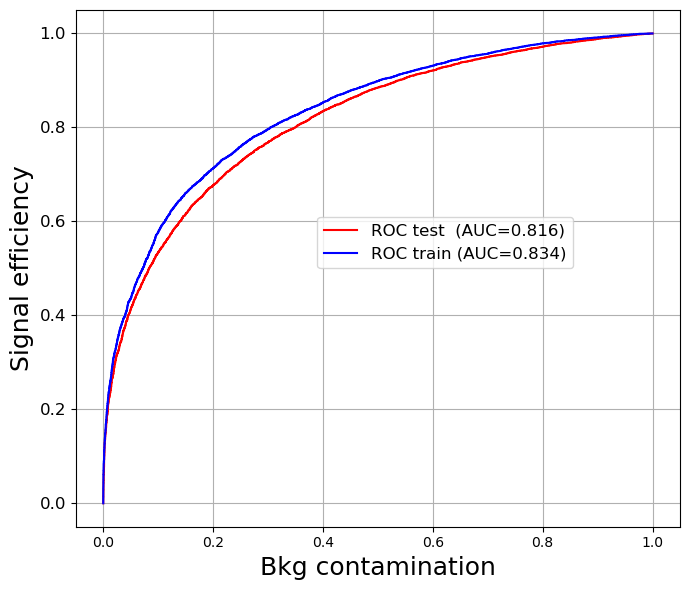

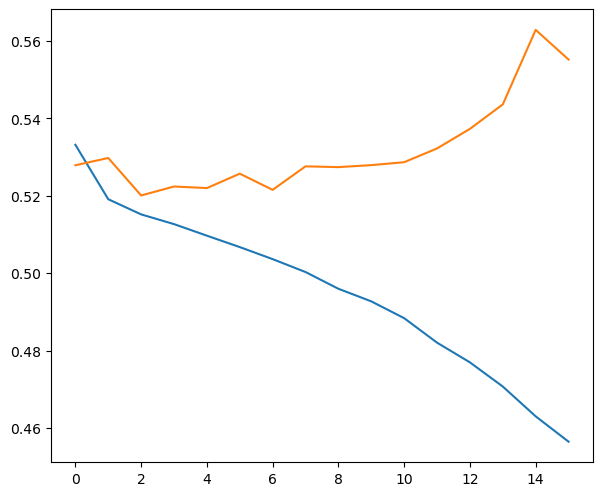

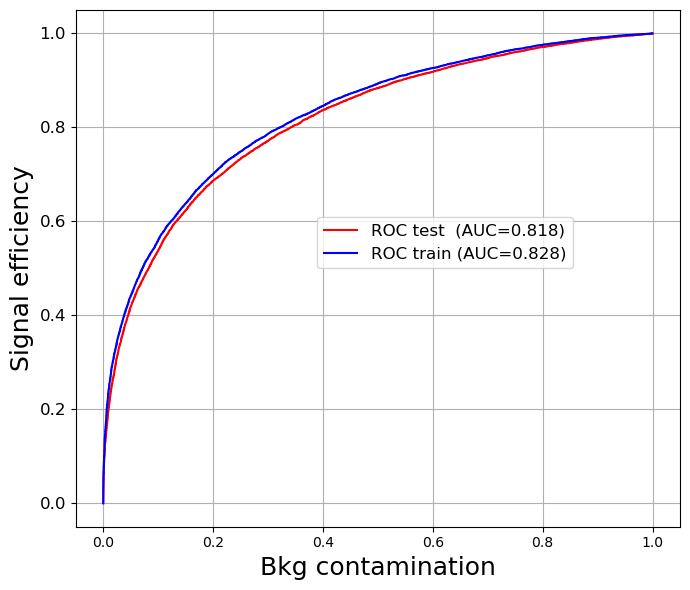

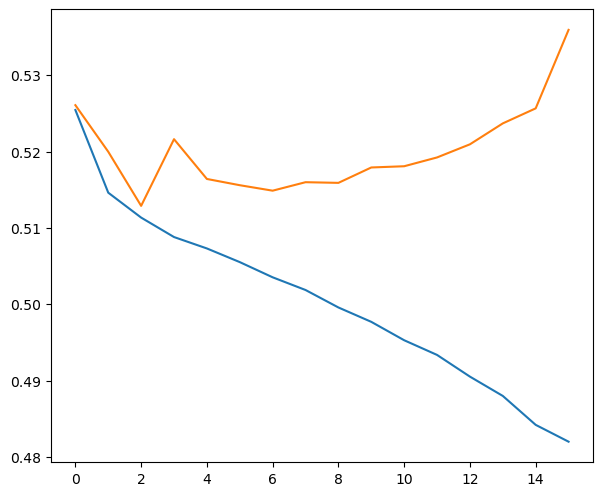

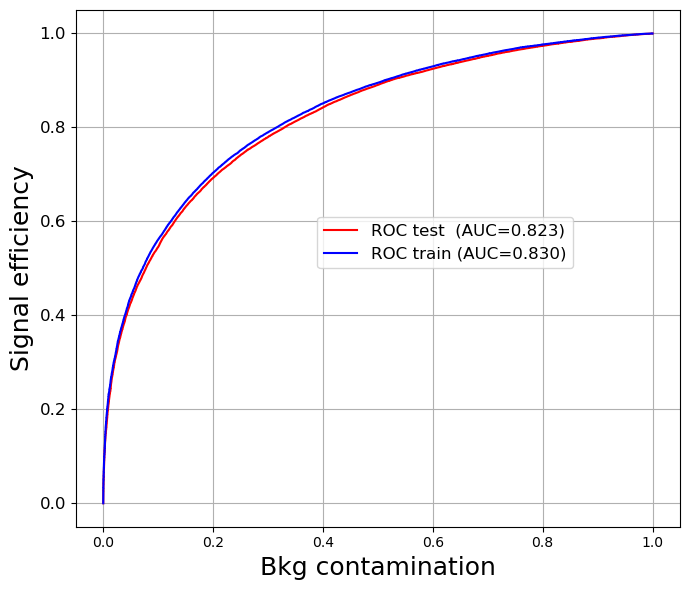

In [71]:
for i in range(2,5):
    for N in [int(x) for x in np.logspace(2.5,5,8)]:
        print(N)
        run(i,64,N,"results_noweights_ntrain.csv") if i==2 else run(i,128,N,"results_noweights_ntrain.csv")    

316
Model: "sequential_88"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_362 (Dense)            (None, 64)                384       
_________________________________________________________________
dense_363 (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_364 (Dense)            (None, 1)                 65        
Total params: 4,609
Trainable params: 4,609
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
10/10 [==============================] - 0s 23ms/step - loss: 0.6762 - accuracy: 0.6108 - val_loss: 0.6700 - val_accuracy: 0.6139
Epoch 2/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6485 - accuracy: 0.6456 - val_loss: 0.6625 - val_accuracy: 0.6108
Epoch 3/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6316 - accuracy: 0.

266/266 [==============================] - 1s 2ms/step - loss: 0.5724 - accuracy: 0.7071 - val_loss: 0.5814 - val_accuracy: 0.6882
Epoch 14/100
266/266 [==============================] - 1s 2ms/step - loss: 0.5724 - accuracy: 0.7071 - val_loss: 0.5803 - val_accuracy: 0.6911
Epoch 15/100
266/266 [==============================] - 1s 2ms/step - loss: 0.5717 - accuracy: 0.7059 - val_loss: 0.5796 - val_accuracy: 0.6937
Epoch 16/100
266/266 [==============================] - 1s 2ms/step - loss: 0.5722 - accuracy: 0.7065 - val_loss: 0.5805 - val_accuracy: 0.6876
Epoch 17/100
266/266 [==============================] - 1s 2ms/step - loss: 0.5713 - accuracy: 0.7047 - val_loss: 0.5811 - val_accuracy: 0.6907
Epoch 18/100
266/266 [==============================] - 1s 2ms/step - loss: 0.5718 - accuracy: 0.7079 - val_loss: 0.5811 - val_accuracy: 0.6911
Epoch 19/100
266/266 [==============================] - 1s 2ms/step - loss: 0.5710 - accuracy: 0.7085 - val_loss: 0.5809 - val_accuracy: 0.6908
>>> C

Epoch 12/100
1374/1374 [==============================] - 3s 2ms/step - loss: 0.5850 - accuracy: 0.6900 - val_loss: 0.5900 - val_accuracy: 0.6864
Epoch 13/100
1374/1374 [==============================] - 3s 2ms/step - loss: 0.5846 - accuracy: 0.6889 - val_loss: 0.5904 - val_accuracy: 0.6875
Epoch 14/100
1374/1374 [==============================] - 3s 2ms/step - loss: 0.5844 - accuracy: 0.6895 - val_loss: 0.5911 - val_accuracy: 0.6867
Epoch 15/100
1374/1374 [==============================] - 3s 2ms/step - loss: 0.5841 - accuracy: 0.6895 - val_loss: 0.5911 - val_accuracy: 0.6861
Epoch 16/100
1374/1374 [==============================] - 3s 2ms/step - loss: 0.5838 - accuracy: 0.6893 - val_loss: 0.5928 - val_accuracy: 0.6854
Epoch 17/100
1374/1374 [==============================] - 3s 2ms/step - loss: 0.5842 - accuracy: 0.6905 - val_loss: 0.5918 - val_accuracy: 0.6837
>>> Computing AUC...
100000
Model: "sequential_95"
_________________________________________________________________
Layer (

Epoch 4/100
23/23 [==============================] - 0s 3ms/step - loss: 0.5894 - accuracy: 0.6954 - val_loss: 0.6005 - val_accuracy: 0.6773
Epoch 5/100
23/23 [==============================] - 0s 3ms/step - loss: 0.5870 - accuracy: 0.6954 - val_loss: 0.6001 - val_accuracy: 0.6759
Epoch 6/100
23/23 [==============================] - 0s 3ms/step - loss: 0.5837 - accuracy: 0.7010 - val_loss: 0.6007 - val_accuracy: 0.6662
Epoch 7/100
23/23 [==============================] - 0s 3ms/step - loss: 0.5828 - accuracy: 0.6982 - val_loss: 0.6012 - val_accuracy: 0.6676
Epoch 8/100
23/23 [==============================] - 0s 3ms/step - loss: 0.5826 - accuracy: 0.6982 - val_loss: 0.6008 - val_accuracy: 0.6634
Epoch 9/100
23/23 [==============================] - 0s 2ms/step - loss: 0.5793 - accuracy: 0.7051 - val_loss: 0.6009 - val_accuracy: 0.6773
Epoch 10/100
23/23 [==============================] - 0s 2ms/step - loss: 0.5777 - accuracy: 0.6982 - val_loss: 0.6019 - val_accuracy: 0.6690
Epoch 11/100

<ipython-input-8-b8941751648a>:93: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax1 = plt.subplots(figsize=(7,6), dpi=100)


3727
Model: "sequential_99"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_395 (Dense)            (None, 64)                384       
_________________________________________________________________
dense_396 (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_397 (Dense)            (None, 1)                 65        
Total params: 4,609
Trainable params: 4,609
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
117/117 [==============================] - 1s 4ms/step - loss: 0.5815 - accuracy: 0.7057 - val_loss: 0.5775 - val_accuracy: 0.6928
Epoch 2/100
117/117 [==============================] - 0s 3ms/step - loss: 0.5597 - accuracy: 0.7156 - val_loss: 0.5710 - val_accuracy: 0.7019
Epoch 3/100
117/117 [==============================] - 0s 2ms/step - loss: 0.5547 - accura

Epoch 1/100
604/604 [==============================] - 2s 3ms/step - loss: 0.5959 - accuracy: 0.6817 - val_loss: 0.5848 - val_accuracy: 0.6881
Epoch 2/100
604/604 [==============================] - 1s 2ms/step - loss: 0.5892 - accuracy: 0.6850 - val_loss: 0.5837 - val_accuracy: 0.6894
Epoch 3/100
604/604 [==============================] - 1s 2ms/step - loss: 0.5882 - accuracy: 0.6870 - val_loss: 0.5826 - val_accuracy: 0.6911
Epoch 4/100
604/604 [==============================] - 2s 3ms/step - loss: 0.5877 - accuracy: 0.6883 - val_loss: 0.5835 - val_accuracy: 0.6880
Epoch 5/100
604/604 [==============================] - 1s 2ms/step - loss: 0.5868 - accuracy: 0.6899 - val_loss: 0.5838 - val_accuracy: 0.6891
Epoch 6/100
604/604 [==============================] - 1s 2ms/step - loss: 0.5866 - accuracy: 0.6874 - val_loss: 0.5840 - val_accuracy: 0.6883
Epoch 7/100
604/604 [==============================] - 1s 2ms/step - loss: 0.5861 - accuracy: 0.6885 - val_loss: 0.5835 - val_accuracy: 0.6904

Epoch 12/100
3125/3125 [==============================] - 6s 2ms/step - loss: 0.5846 - accuracy: 0.6896 - val_loss: 0.5876 - val_accuracy: 0.6874
Epoch 13/100
3125/3125 [==============================] - 6s 2ms/step - loss: 0.5846 - accuracy: 0.6902 - val_loss: 0.5869 - val_accuracy: 0.6878
Epoch 14/100
3125/3125 [==============================] - 6s 2ms/step - loss: 0.5846 - accuracy: 0.6910 - val_loss: 0.5869 - val_accuracy: 0.6876
Epoch 15/100
3125/3125 [==============================] - 6s 2ms/step - loss: 0.5843 - accuracy: 0.6903 - val_loss: 0.5866 - val_accuracy: 0.6887
Epoch 16/100
3125/3125 [==============================] - 6s 2ms/step - loss: 0.5844 - accuracy: 0.6905 - val_loss: 0.5866 - val_accuracy: 0.6879
Epoch 17/100
3125/3125 [==============================] - 6s 2ms/step - loss: 0.5842 - accuracy: 0.6905 - val_loss: 0.5873 - val_accuracy: 0.6873
>>> Computing AUC...
316
Model: "sequential_104"
_________________________________________________________________
Layer (ty

52/52 [==============================] - 0s 6ms/step - loss: 0.6052 - accuracy: 0.6836 - val_loss: 0.5954 - val_accuracy: 0.6909
Epoch 2/100
52/52 [==============================] - 0s 3ms/step - loss: 0.5500 - accuracy: 0.7208 - val_loss: 0.5956 - val_accuracy: 0.6927
Epoch 3/100
52/52 [==============================] - 0s 2ms/step - loss: 0.5420 - accuracy: 0.7349 - val_loss: 0.5928 - val_accuracy: 0.6927
Epoch 4/100
52/52 [==============================] - 0s 2ms/step - loss: 0.5405 - accuracy: 0.7294 - val_loss: 0.5893 - val_accuracy: 0.6933
Epoch 5/100
52/52 [==============================] - 0s 2ms/step - loss: 0.5395 - accuracy: 0.7349 - val_loss: 0.5929 - val_accuracy: 0.6909
Epoch 6/100
52/52 [==============================] - 0s 2ms/step - loss: 0.5374 - accuracy: 0.7361 - val_loss: 0.5942 - val_accuracy: 0.6891
Epoch 7/100
52/52 [==============================] - 0s 2ms/step - loss: 0.5383 - accuracy: 0.7361 - val_loss: 0.5923 - val_accuracy: 0.6927
Epoch 8/100
52/52 [======

Epoch 8/100
1374/1374 [==============================] - 3s 2ms/step - loss: 0.5855 - accuracy: 0.6889 - val_loss: 0.5908 - val_accuracy: 0.6863
Epoch 9/100
1374/1374 [==============================] - 3s 2ms/step - loss: 0.5858 - accuracy: 0.6884 - val_loss: 0.5908 - val_accuracy: 0.6875
Epoch 10/100
1374/1374 [==============================] - 3s 2ms/step - loss: 0.5856 - accuracy: 0.6898 - val_loss: 0.5911 - val_accuracy: 0.6855
Epoch 11/100
1374/1374 [==============================] - 3s 2ms/step - loss: 0.5854 - accuracy: 0.6899 - val_loss: 0.5910 - val_accuracy: 0.6869
Epoch 12/100
1374/1374 [==============================] - 2s 2ms/step - loss: 0.5852 - accuracy: 0.6895 - val_loss: 0.5901 - val_accuracy: 0.6875
Epoch 13/100
1374/1374 [==============================] - 3s 2ms/step - loss: 0.5851 - accuracy: 0.6884 - val_loss: 0.5915 - val_accuracy: 0.6881
Epoch 14/100
1374/1374 [==============================] - 3s 2ms/step - loss: 0.5847 - accuracy: 0.6897 - val_loss: 0.5906 - v

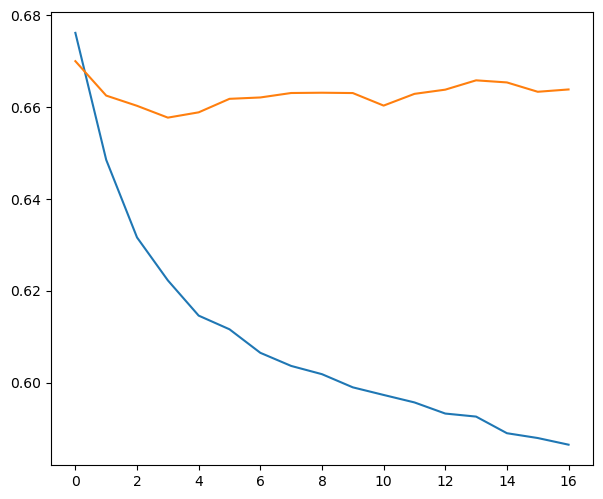

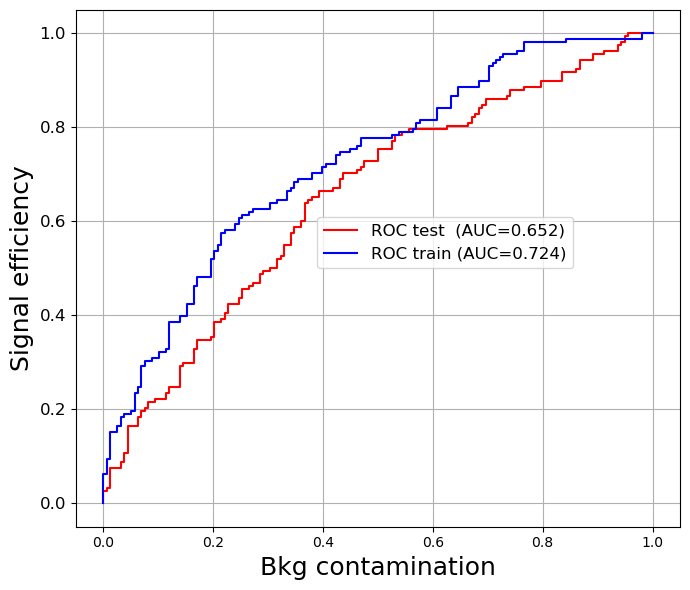

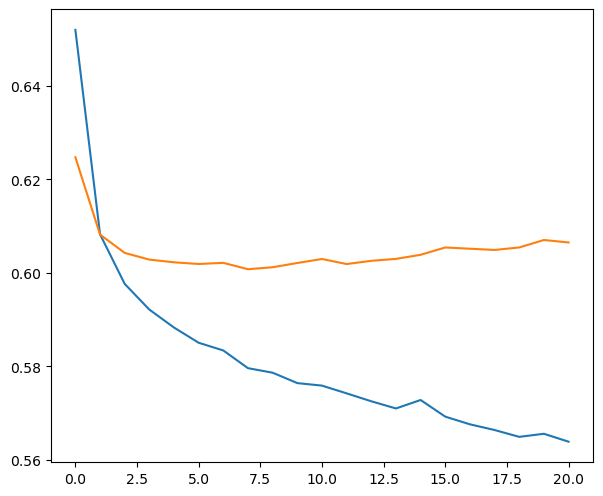

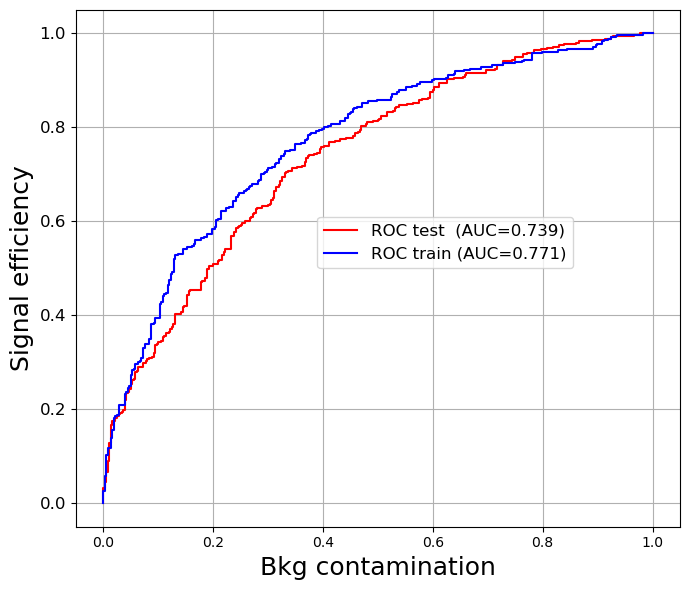

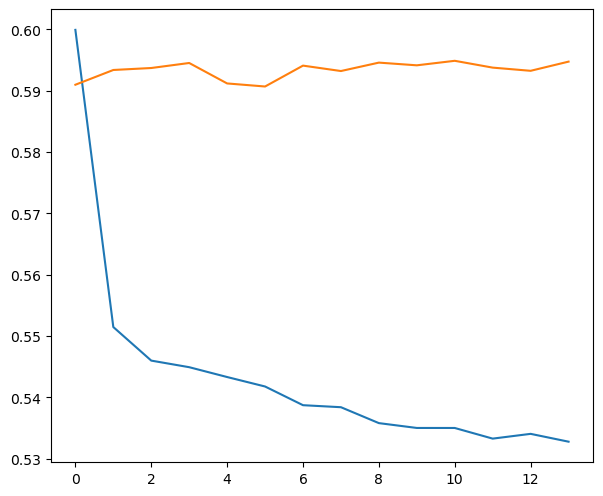

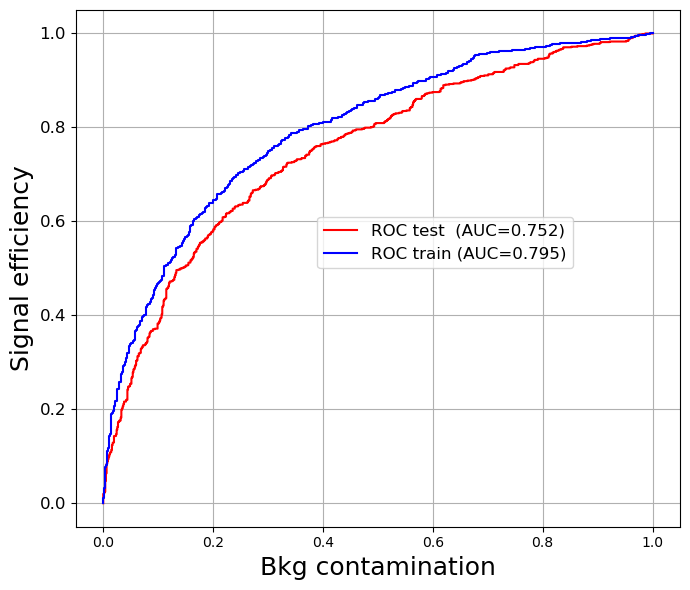

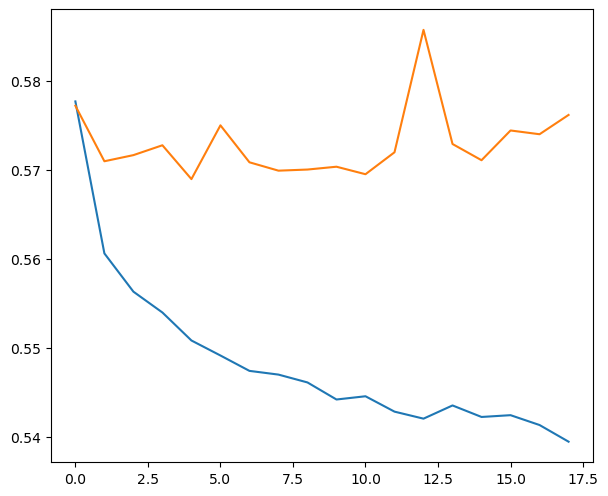

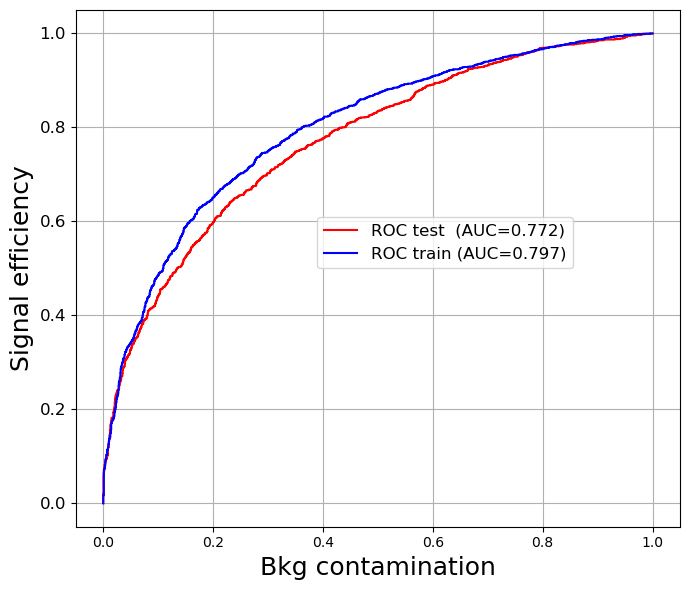

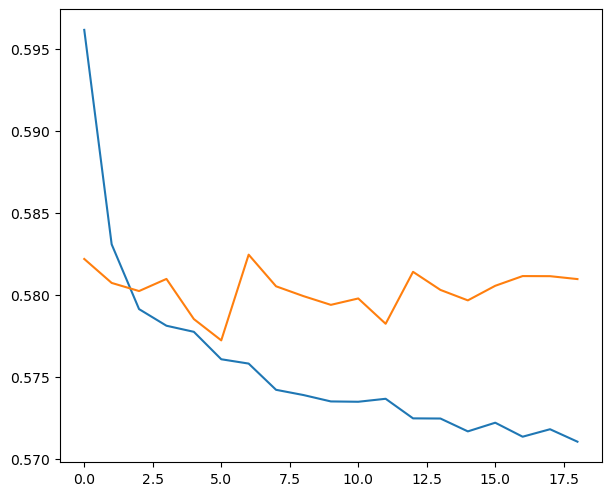

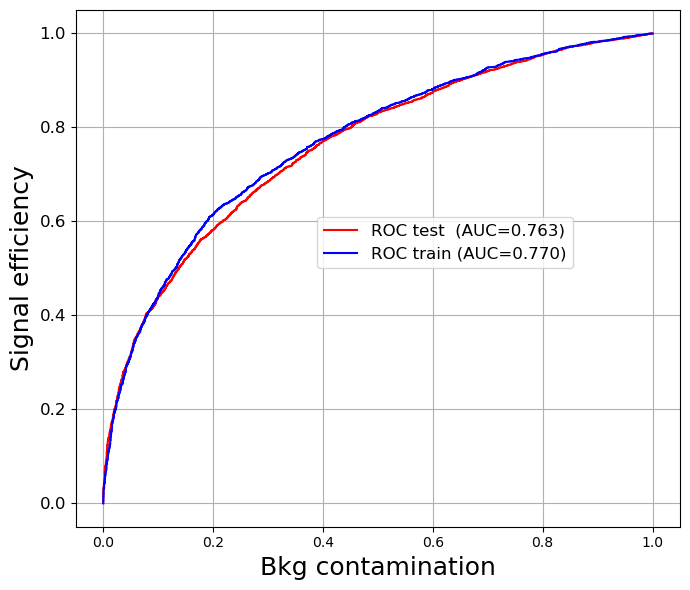

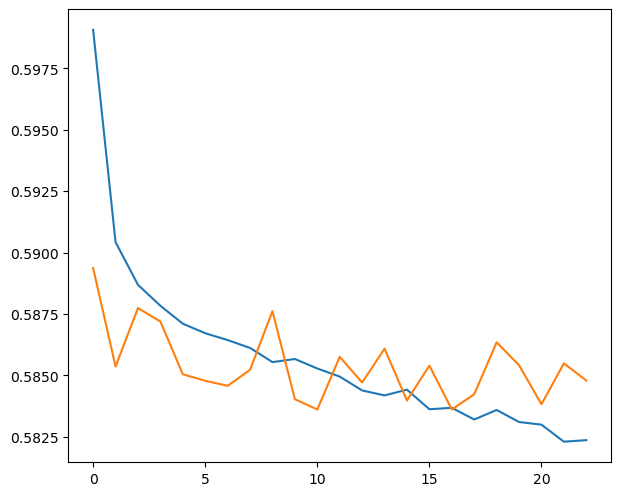

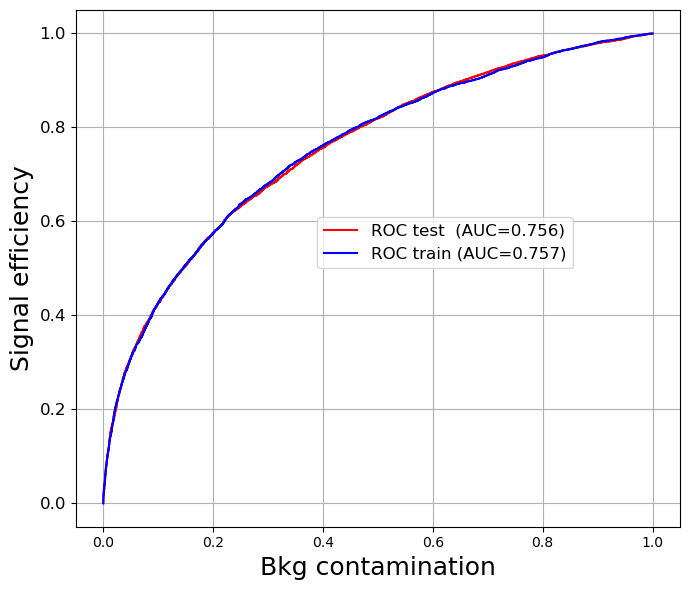

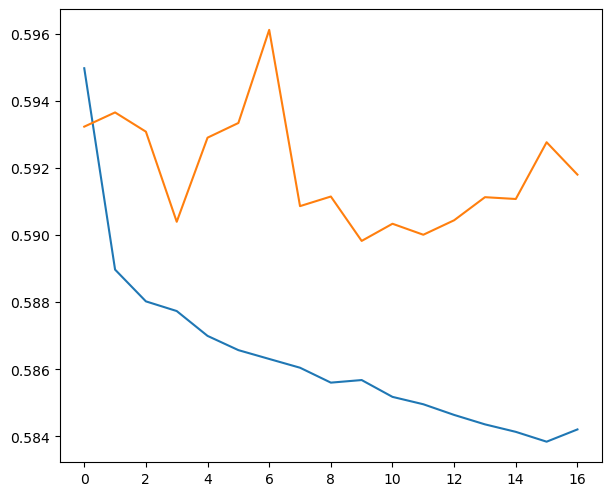

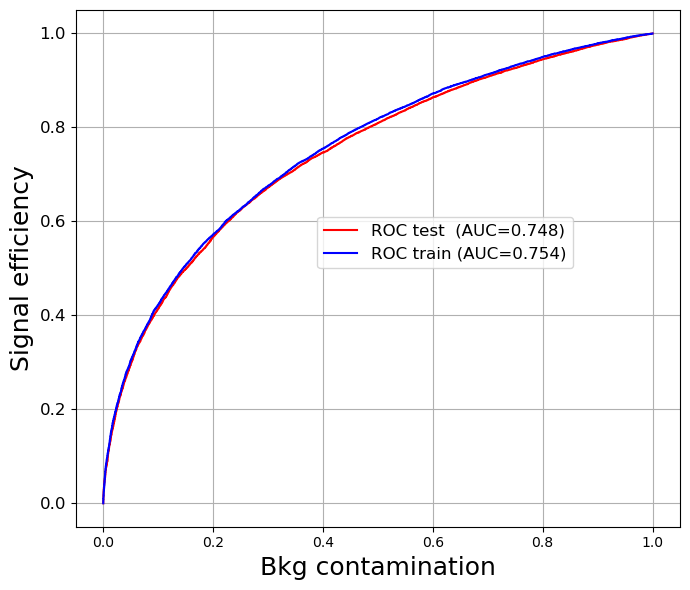

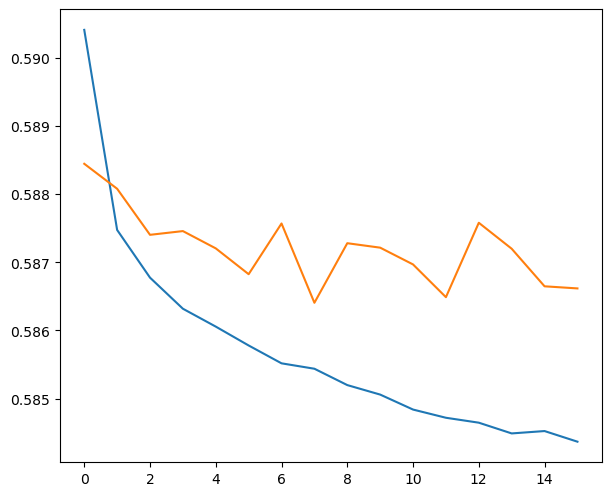

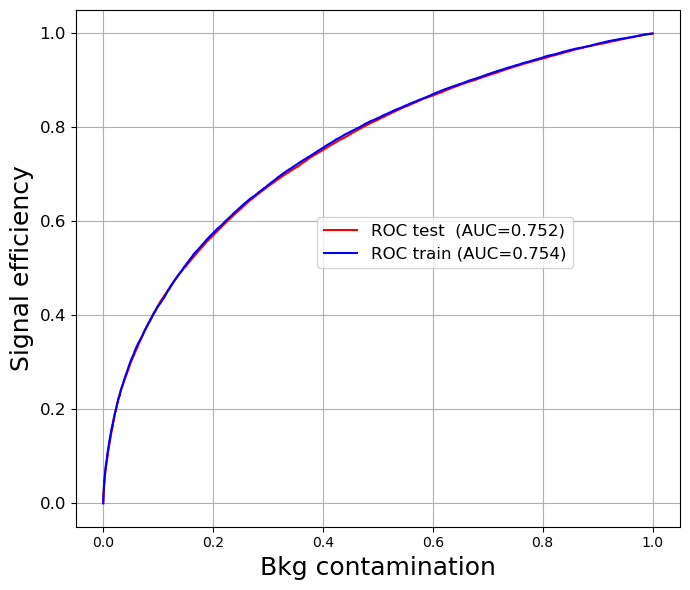

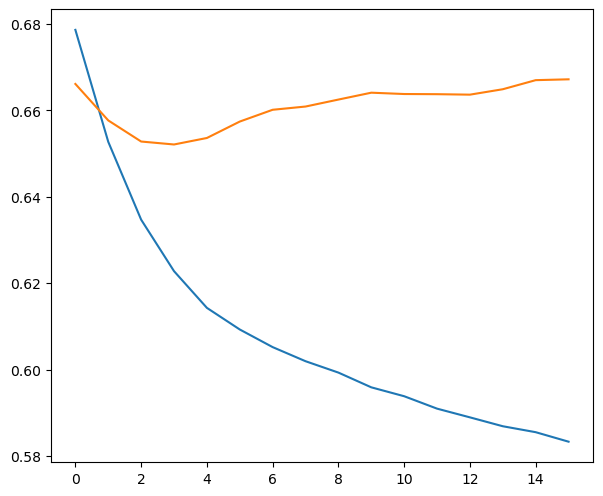

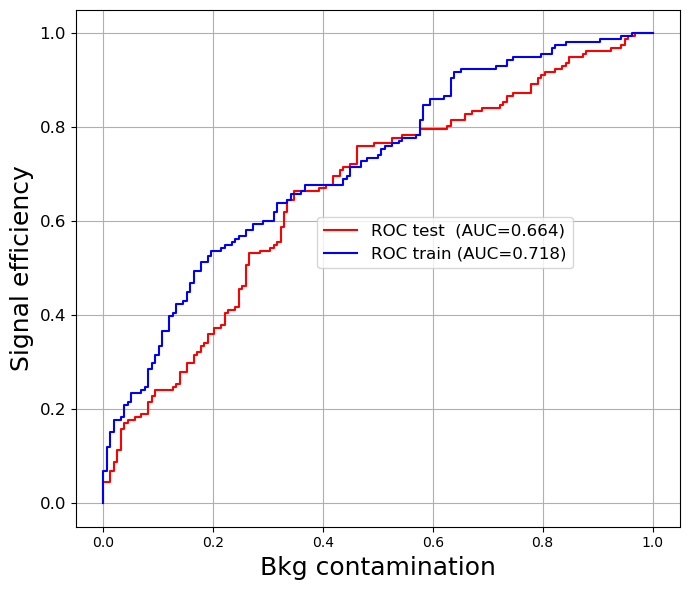

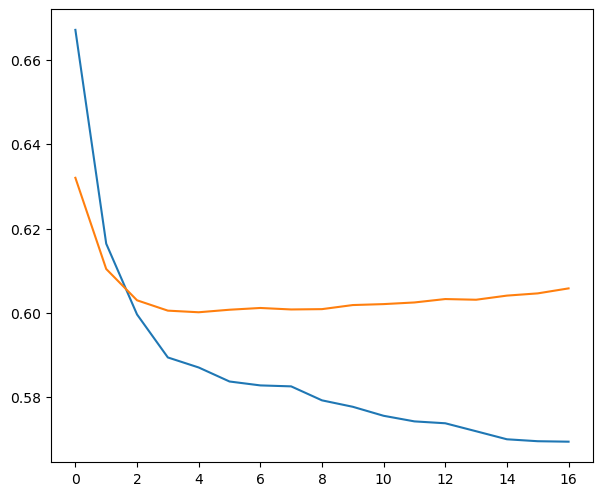

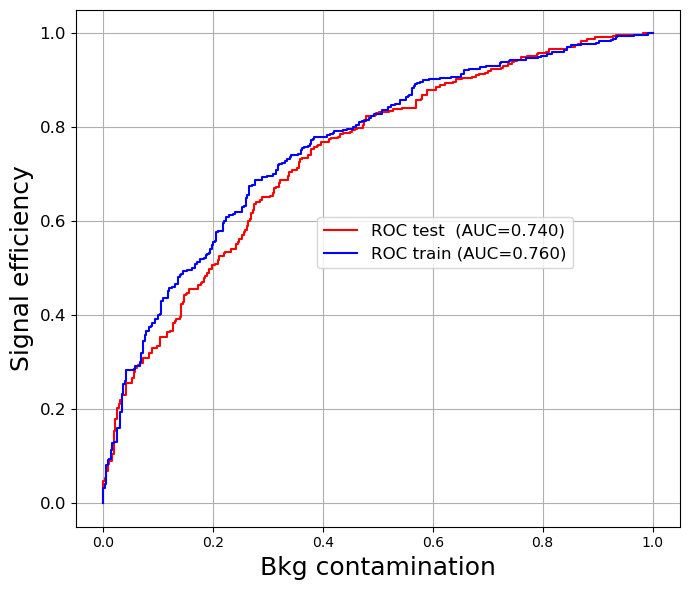

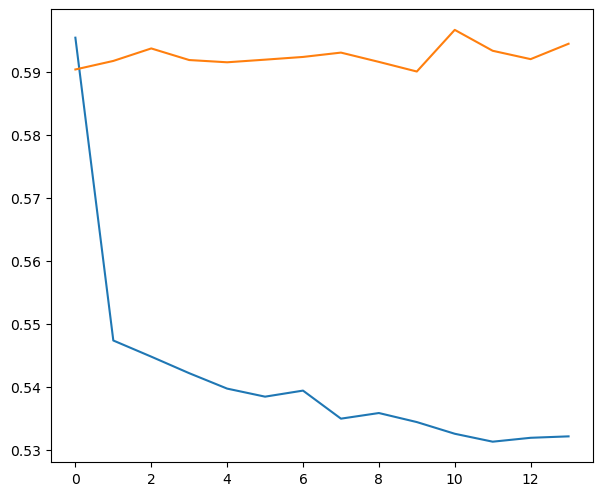

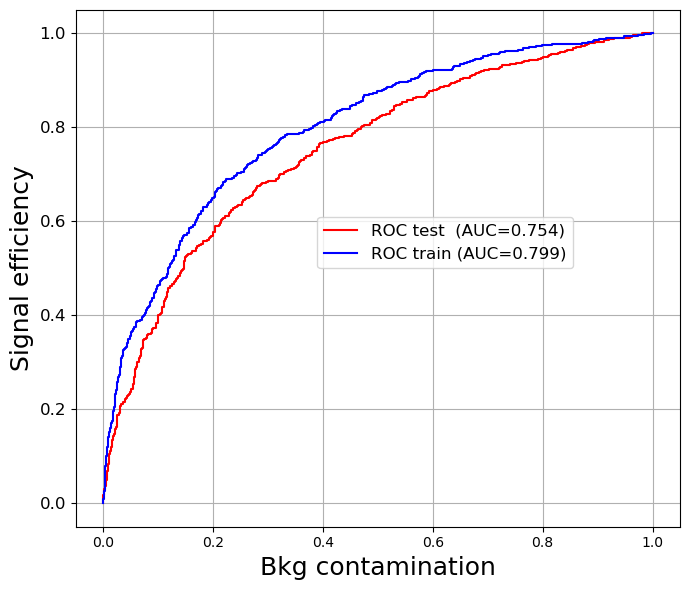

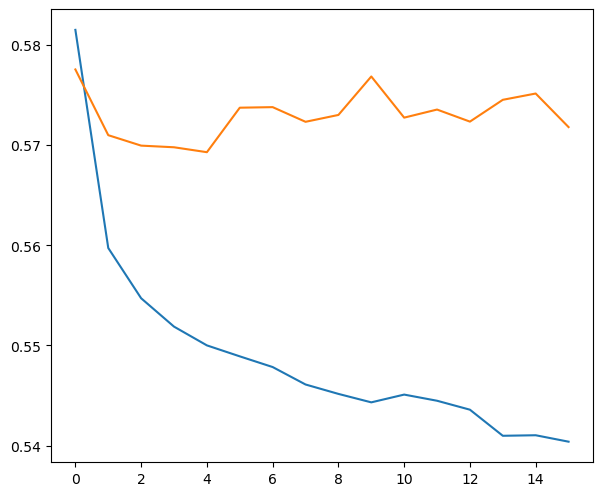

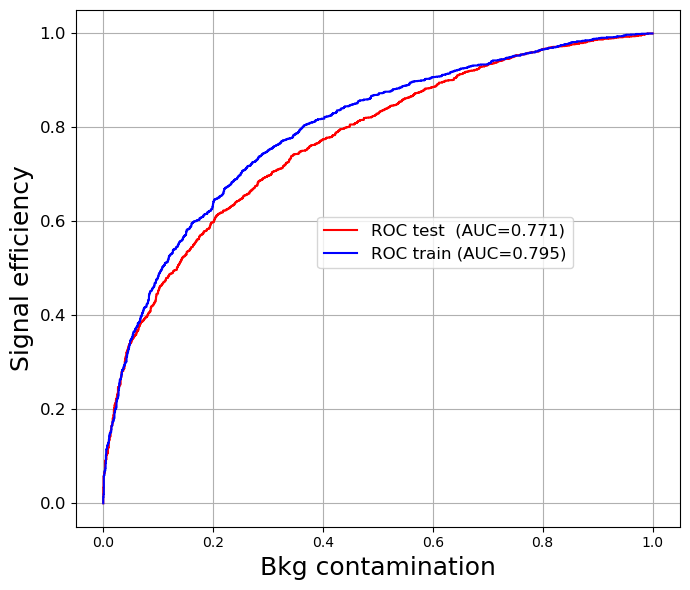

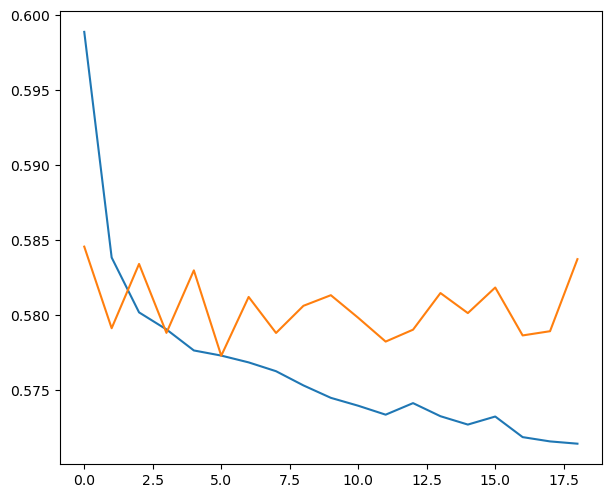

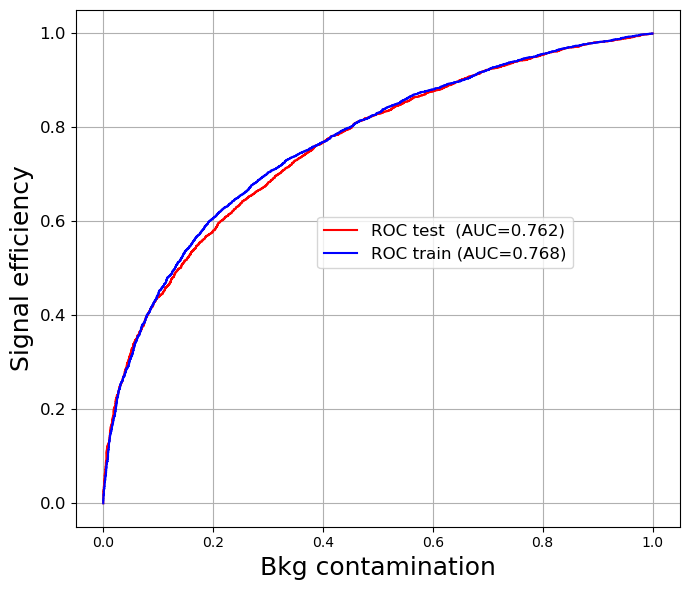

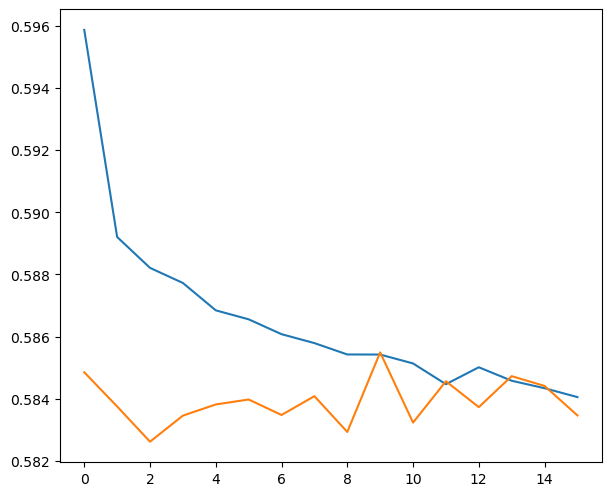

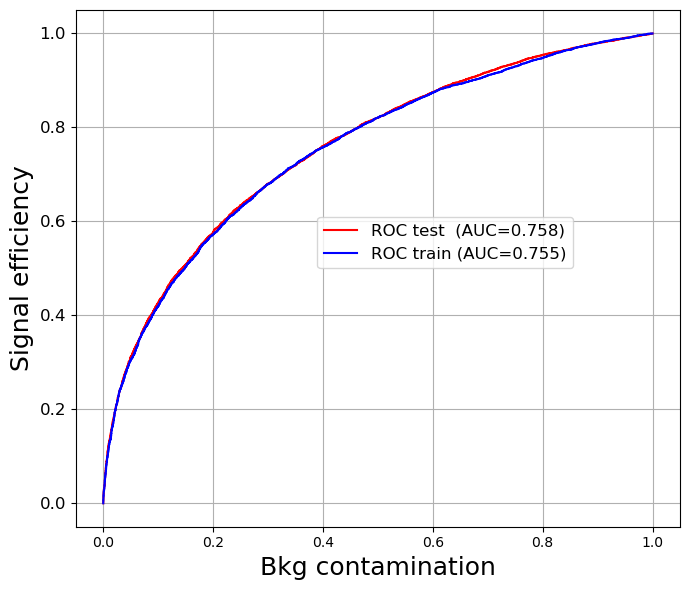

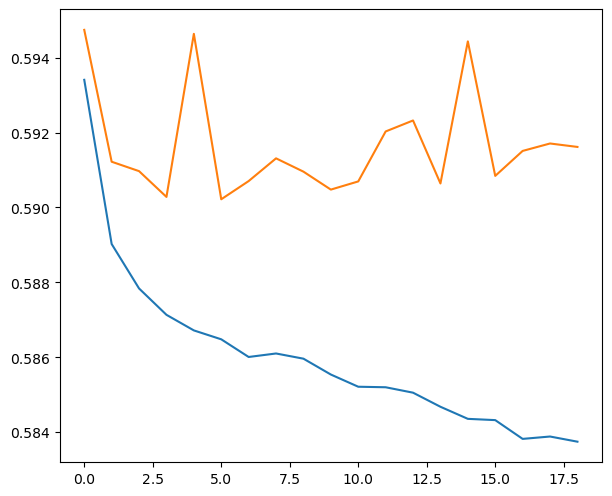

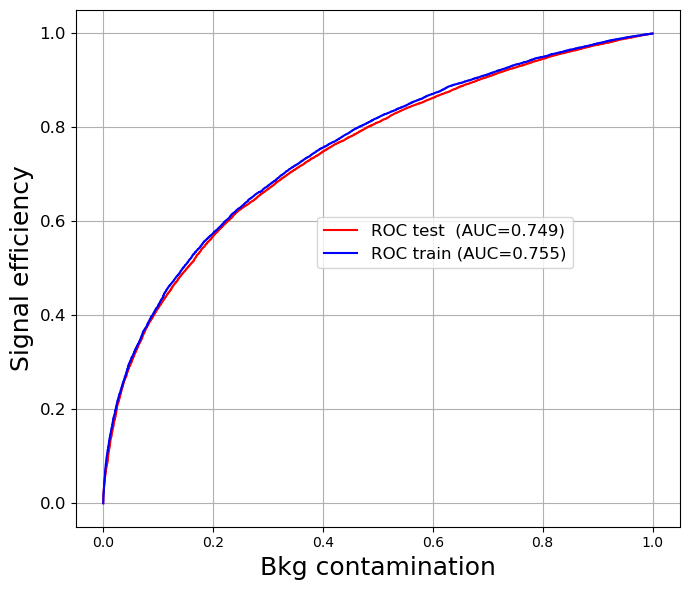

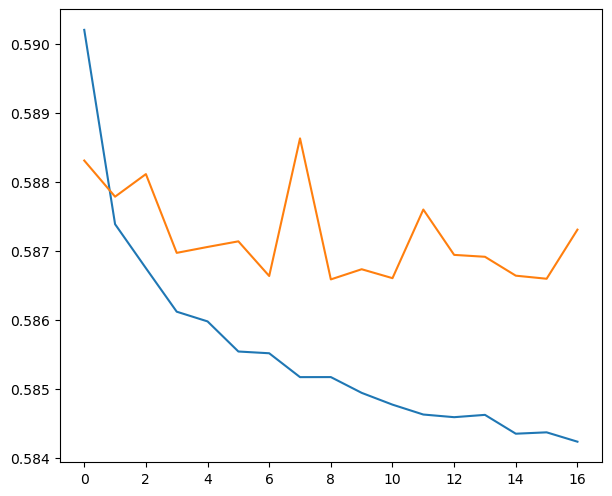

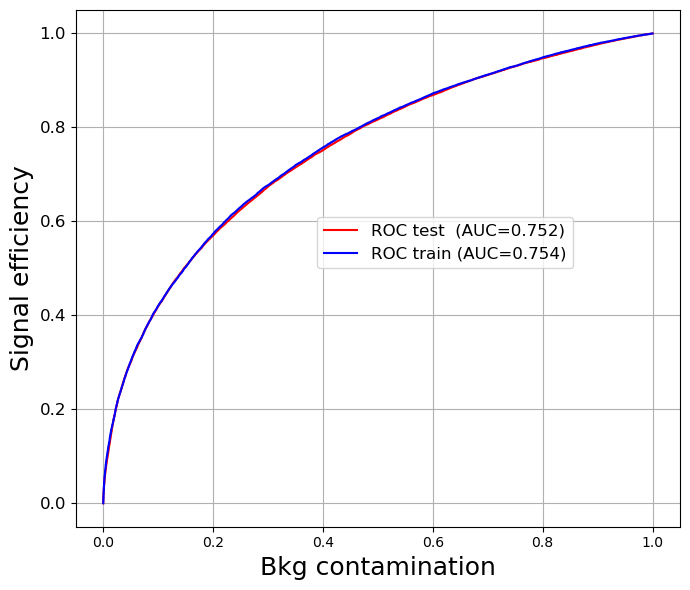

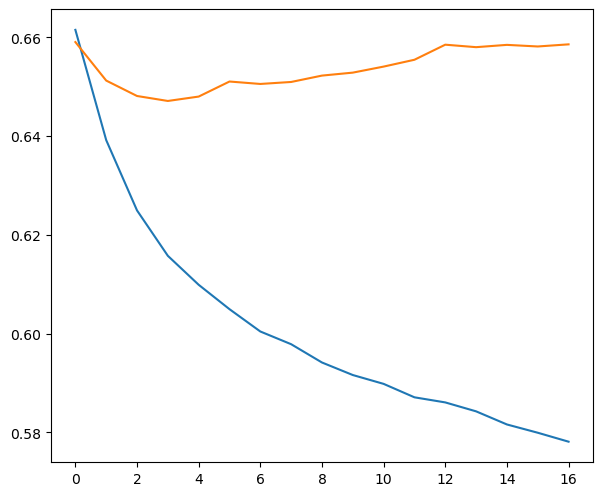

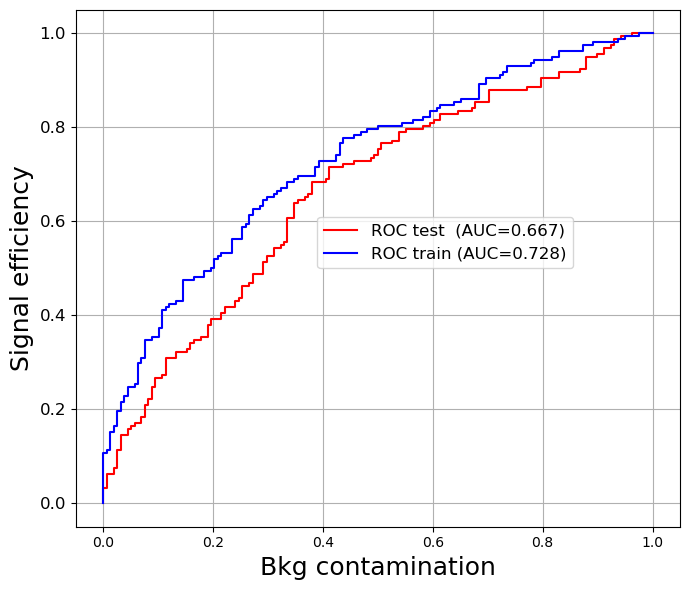

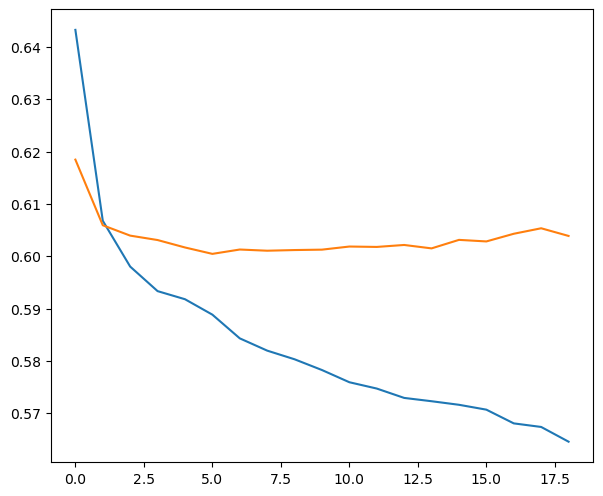

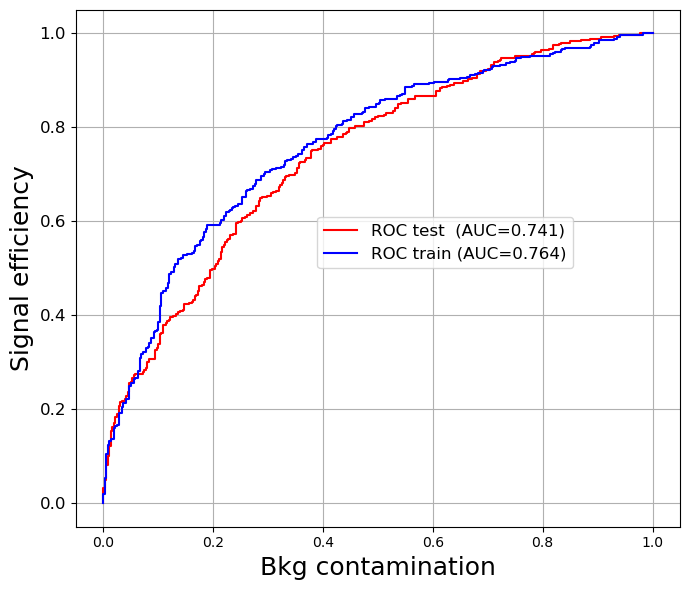

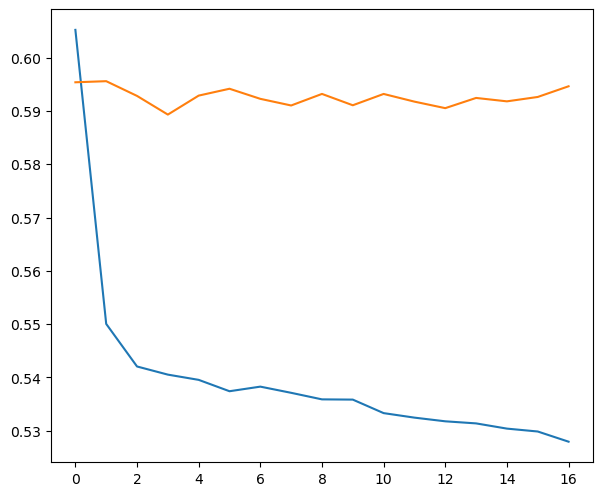

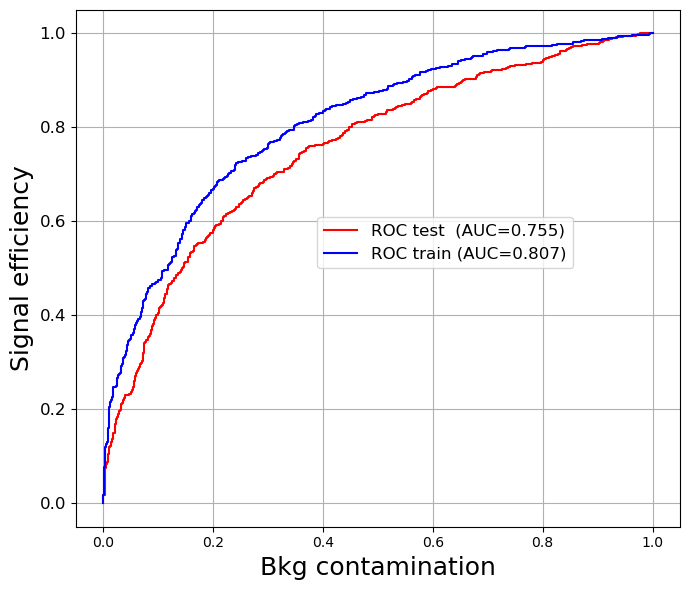

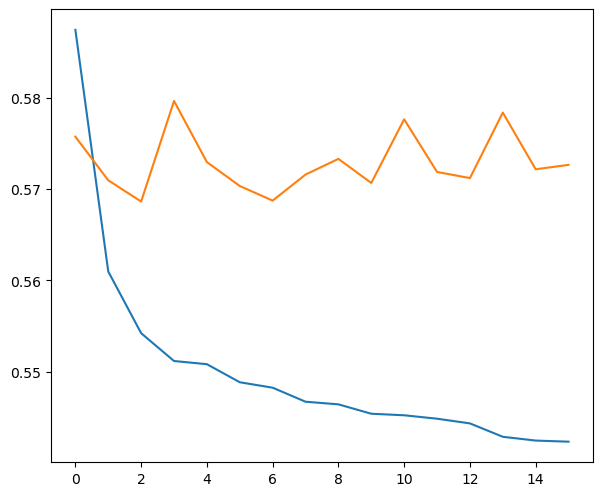

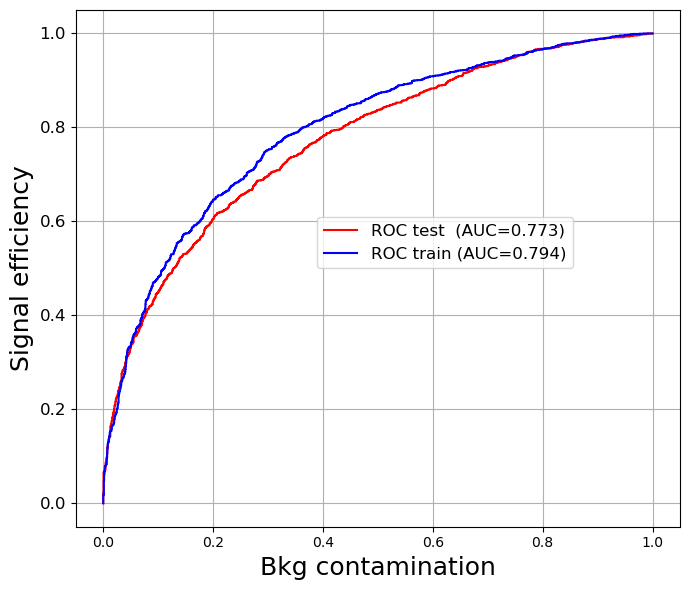

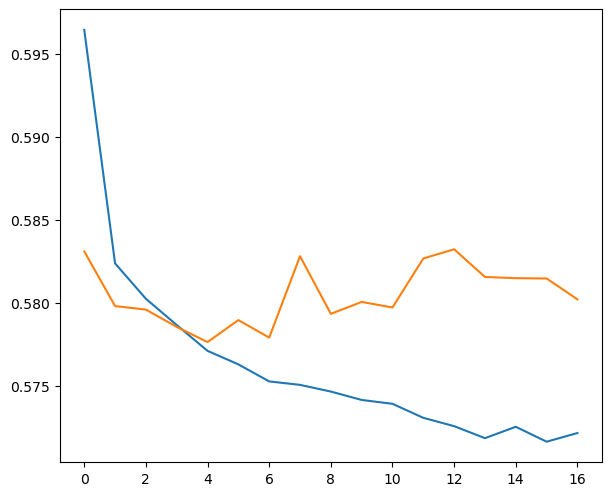

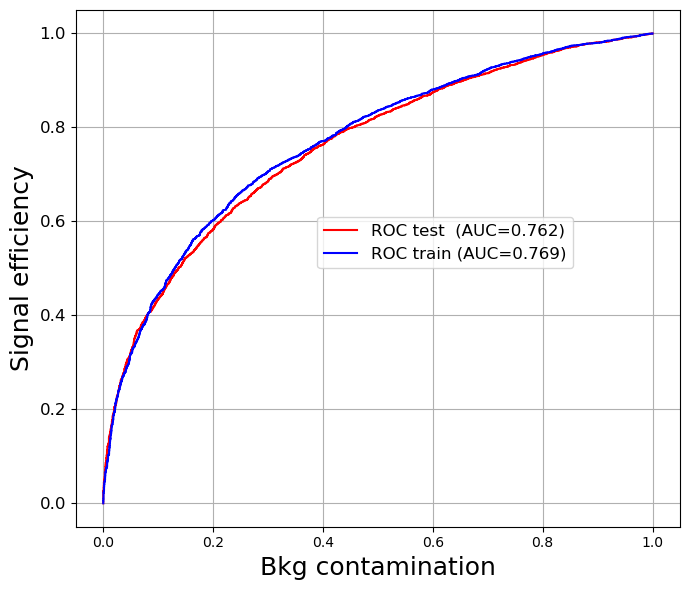

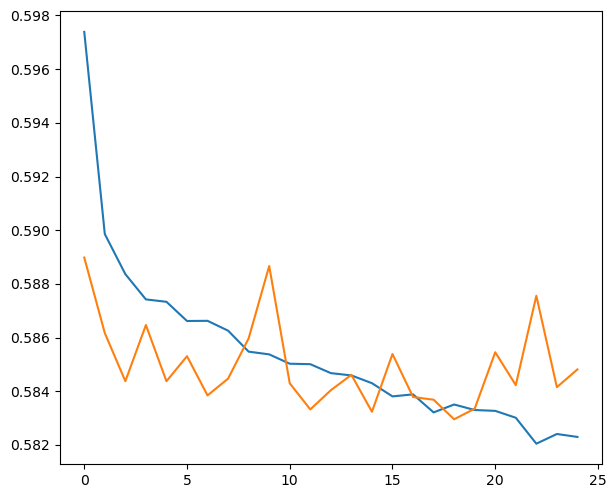

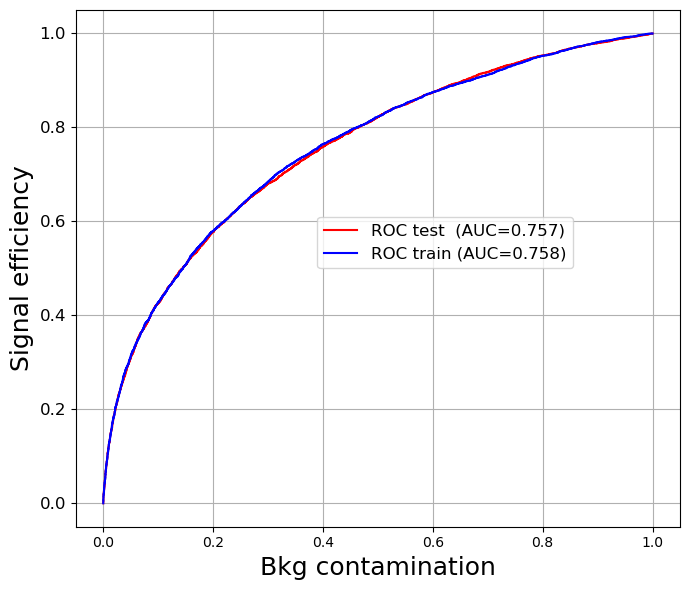

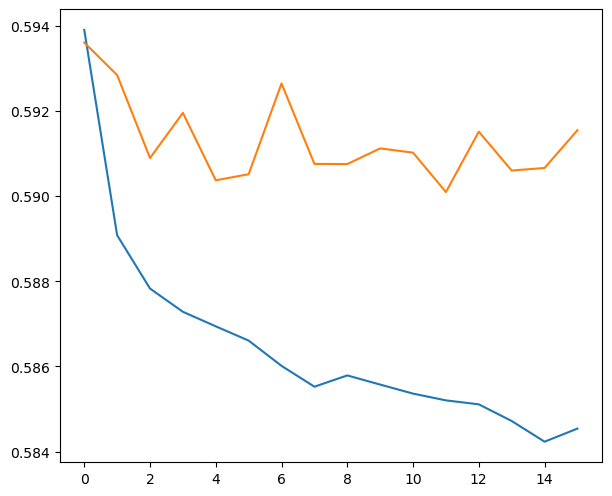

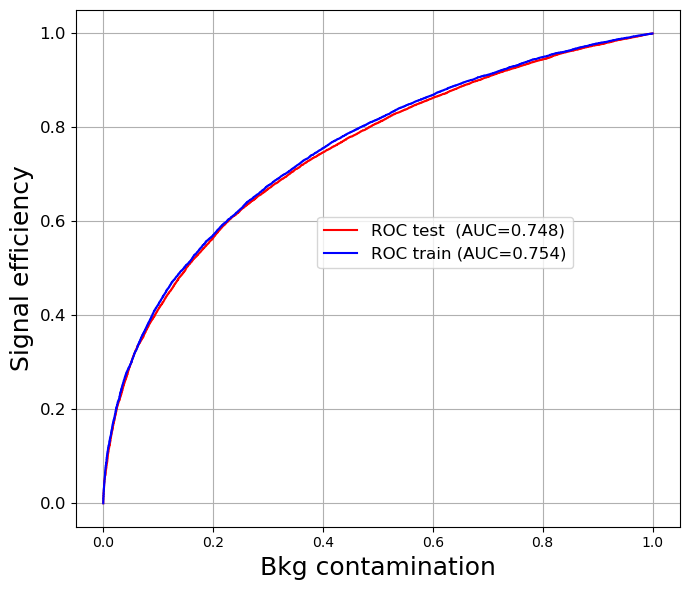

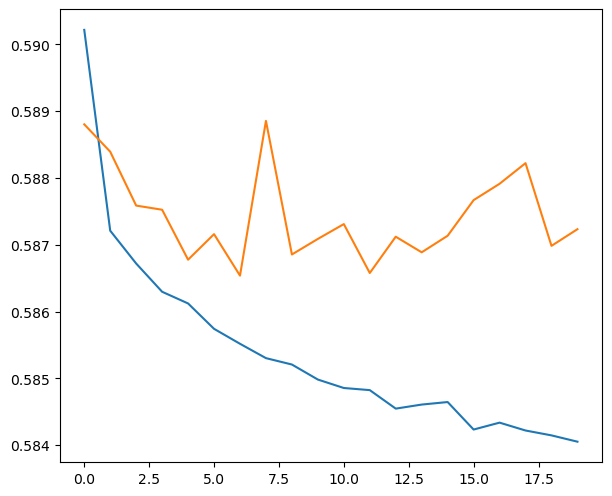

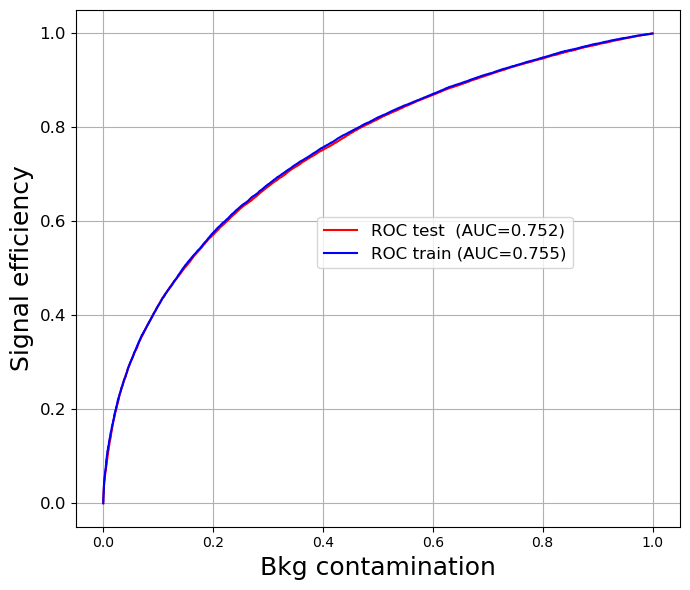

In [78]:
for i in range(2,5):
    for N in [int(x) for x in np.logspace(2.5,5,8)]:
        print(N)
        run(i,64,N,"results_noweights_ntrain.csv") 

19306
Model: "sequential_139"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_545 (Dense)            (None, 128)               768       
_________________________________________________________________
dense_546 (Dense)            (None, 128)               16512     
_________________________________________________________________
dense_547 (Dense)            (None, 128)               16512     
_________________________________________________________________
dense_548 (Dense)            (None, 128)               16512     
_________________________________________________________________
dense_549 (Dense)            (None, 1)                 129       
Total params: 50,433
Trainable params: 50,433
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
604/604 [==============================] - 3s 4ms/step - loss: 0.5985 - accuracy: 0.6784 - val_l

3125/3125 [==============================] - 12s 4ms/step - loss: 0.5916 - accuracy: 0.6847 - val_loss: 0.5893 - val_accuracy: 0.6855
Epoch 2/100
3125/3125 [==============================] - 12s 4ms/step - loss: 0.5882 - accuracy: 0.6876 - val_loss: 0.5898 - val_accuracy: 0.6865
Epoch 3/100
3125/3125 [==============================] - 12s 4ms/step - loss: 0.5877 - accuracy: 0.6878 - val_loss: 0.5888 - val_accuracy: 0.6879
Epoch 4/100
3125/3125 [==============================] - 11s 4ms/step - loss: 0.5870 - accuracy: 0.6883 - val_loss: 0.5920 - val_accuracy: 0.6882
Epoch 5/100
3125/3125 [==============================] - 12s 4ms/step - loss: 0.5868 - accuracy: 0.6894 - val_loss: 0.5871 - val_accuracy: 0.6885
Epoch 6/100
3125/3125 [==============================] - 12s 4ms/step - loss: 0.5862 - accuracy: 0.6901 - val_loss: 0.5870 - val_accuracy: 0.6879
Epoch 7/100
3125/3125 [==============================] - 11s 4ms/step - loss: 0.5859 - accuracy: 0.6904 - val_loss: 0.5871 - val_accurac

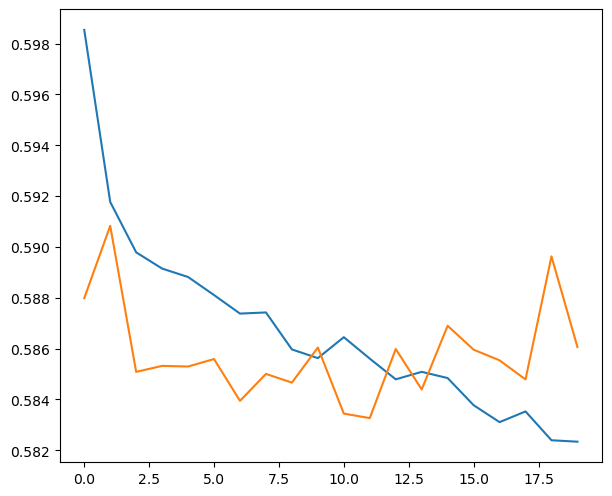

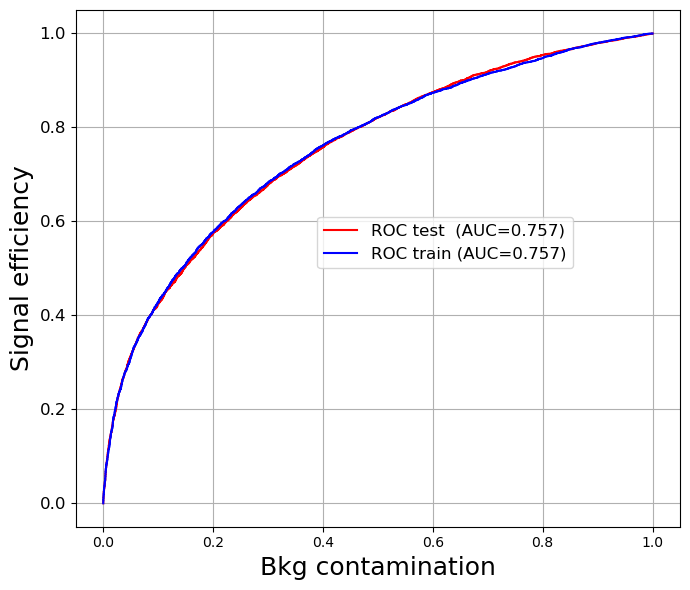

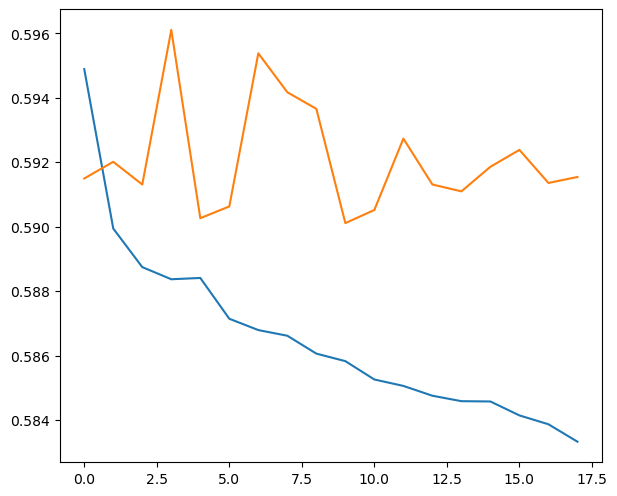

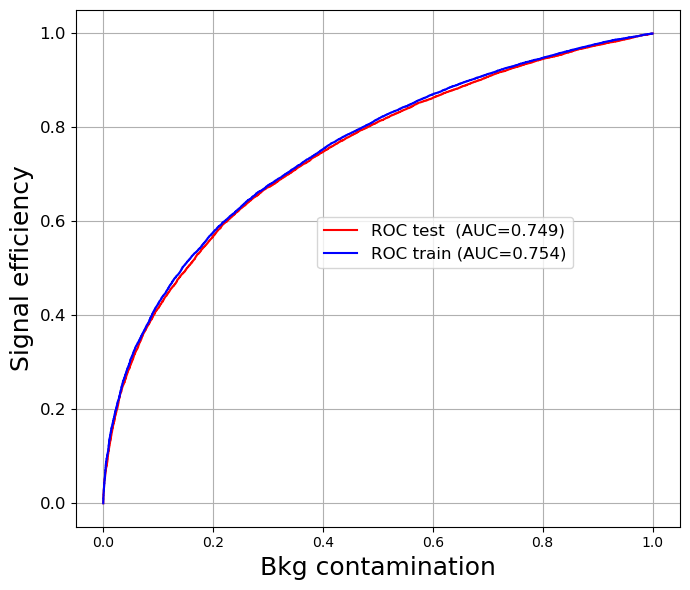

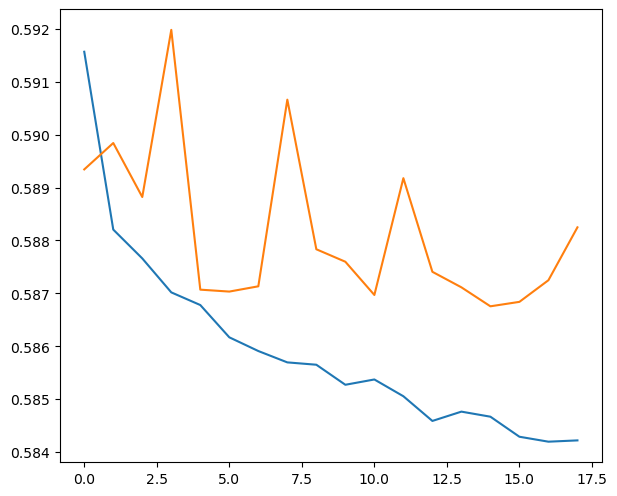

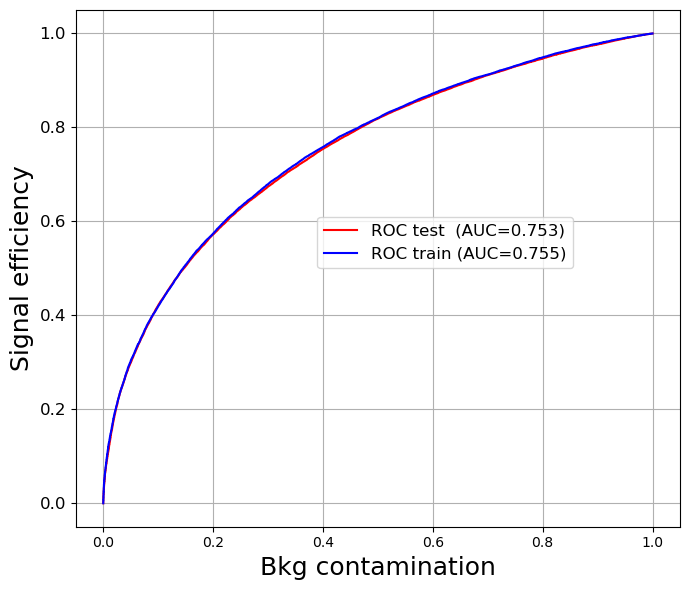

In [92]:
for N in [19306,43939,100000]:
        print(N)
        run(4,128,N,"results_noweights_ntrain.csv") 

Text(0, 0.5, 'AUC')

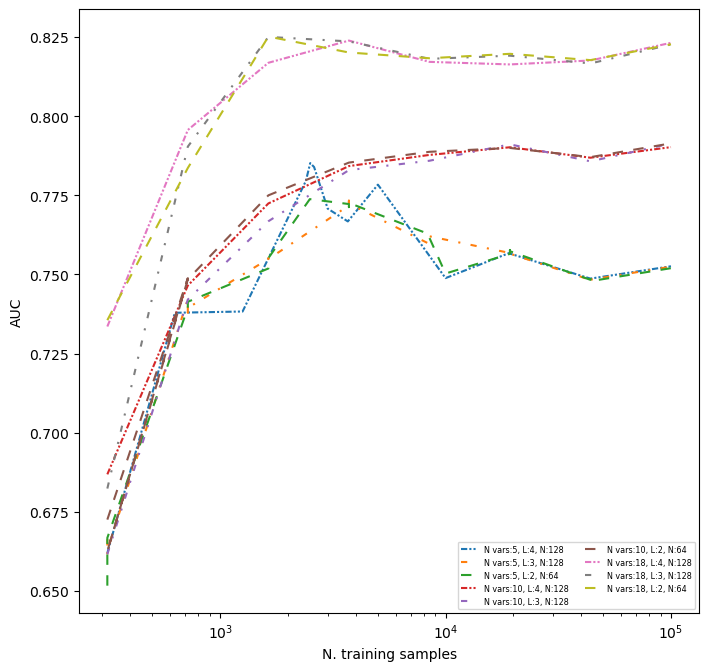

In [93]:
df = pd.read_csv("results_noweights_ntrain.csv",sep=";")

fig, ax1 = plt.subplots(figsize=(8,8), dpi=100)
linestyle_tuple = [
     ('dotted',                (0, (1, 1))),

     ('dashed',                (0, (5, 5))),

     ('dashdotted',            (0, (3, 5, 1, 5))),

     ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1)))]

for nvar in [5]:
    for arch in [[4,128],[3,128],[2,64]]:
        a = df[(df.nodes==arch[1])& (df.layers==arch[0])  & (df.nvars == nvar)]
        ax1.plot(a.ntrain, a.auc_val, label="N vars:{}, L:{}, N:{}".format(nvar, arch[0], arch[1]), linestyle=linestyle_tuple[arch[0]-1][1])
for nvar in [10]:
    for arch in [[4,128],[3,128],[2,64]]:
        a = df[(df.nodes==arch[1])& (df.layers==arch[0])  & (df.nvars == nvar)]
        ax1.plot(a.ntrain, a.auc_val, label="N vars:{}, L:{}, N:{}".format(nvar, arch[0], arch[1]), linestyle=linestyle_tuple[arch[0]-1][1])
for nvar in [18]:
    for arch in [[4,128],[3,128],[2,64]]:
        a = df[(df.nodes==arch[1])& (df.layers==arch[0])  & (df.nvars == nvar)]
        ax1.plot(a.ntrain, a.auc_val, label="N vars:{}, L:{}, N:{}".format(nvar, arch[0], arch[1]), linestyle=linestyle_tuple[arch[0]-1][1])
ax1.legend(fontsize="xx-small",ncol=2)
ax1.set_xscale("log")
ax1.set_xlabel("N. training samples")
ax1.set_ylabel("AUC")

In [85]:
print(arch[1])

64
